# Imports

In [1]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

# Visualizing Results

In [3]:
in_dir = "/content/drive/MyDrive/dataset"
model_dir = "/content/drive/MyDrive/liver_segmentation"

In [4]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))

test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

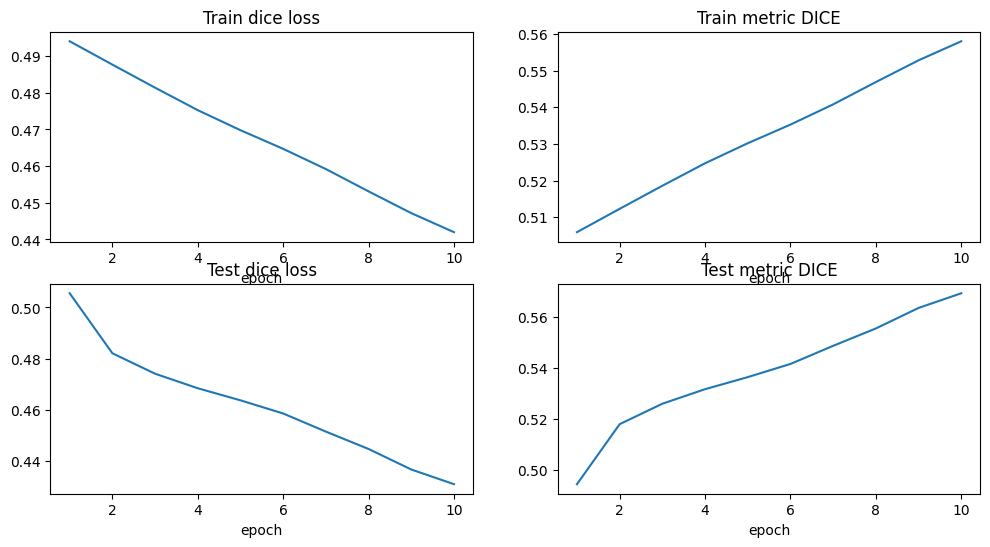

In [5]:
plt.figure("Results: ", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

# Preparing train-test files

In [6]:
# volumes - holds the file paths to the train/test volume images
# segmentation -  holds the file paths to the corresponding segmentation masks for training/testing

path_train_volumes = sorted(glob(os.path.join(in_dir, "train_image", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "train_label", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "test_image", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "test_label", "*.nii.gz")))


In [7]:
path_train_volumes

['/content/drive/MyDrive/dataset/train_image/liver_0_0.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_1_0.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_2_5.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_2_6.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_2_7.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_4.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_5.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_6.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_7.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_5.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_6.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_7.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_8.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_9.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_5_4.nii.gz',
 '/content/drive/MyDrive/dataset/train_i

In [8]:
path_test_volumes

['/content/drive/MyDrive/dataset/test_image/liver_9_5.nii.gz',
 '/content/drive/MyDrive/dataset/test_image/liver_9_6.nii.gz',
 '/content/drive/MyDrive/dataset/test_image/liver_9_7.nii.gz']

In [9]:
# Create lists of dictionaries to pair each training and testing volume image with its corresponding segmentation mask
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

In [10]:
train_files

[{'image': '/content/drive/MyDrive/dataset/train_image/liver_0_0.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_0_0.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_1_0.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_1_0.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_2_5.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_2_5.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_2_6.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_2_6.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_2_7.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_2_7.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_3_4.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_3_4.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_3_5.nii.gz',
  'label': '/content/drive/MyDri

In [11]:
test_files

[{'image': '/content/drive/MyDrive/dataset/test_image/liver_9_5.nii.gz',
  'label': '/content/drive/MyDrive/dataset/test_label/liver_9_5.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/test_image/liver_9_6.nii.gz',
  'label': '/content/drive/MyDrive/dataset/test_label/liver_9_6.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/test_image/liver_9_7.nii.gz',
  'label': '/content/drive/MyDrive/dataset/test_label/liver_9_7.nii.gz'}]

# Test - Transforms, Dataset & DataLoader

In [12]:
# Preprocessing - as training
test_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        ScaleIntensityRanged(keys='image', a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[128,128,128]),
        ToTensord(keys=['image', 'label'])
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

In [13]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [14]:
test_ds[0]

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

In [15]:
loader = iter(test_loader)
next(loader)

{'image': metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           ...,
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...

# Testing

In [21]:
# Load the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    spatial_dims=3, # Indicates a 3D U-Net model
    in_channels=1,  # Indicates a 3D U-Net model
    out_channels=2, # Number of output channels (e.g., for segmentation tasks)
    channels=(16, 32, 64, 128, 256),  # Number of channels at each U-Net layer
    strides=(2, 2, 2, 2), # Spatial down-sampling strides
    num_res_units=2, # Number of residual units
    norm=Norm.BATCH).to(device) # Type of normalization (e.g., batch normalization)


In [22]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


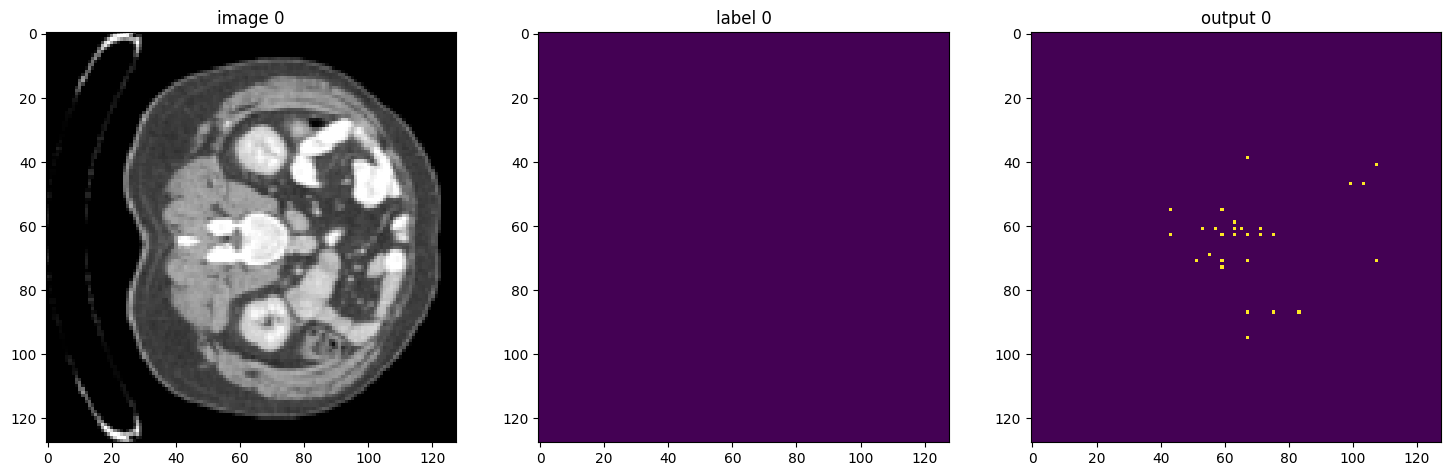

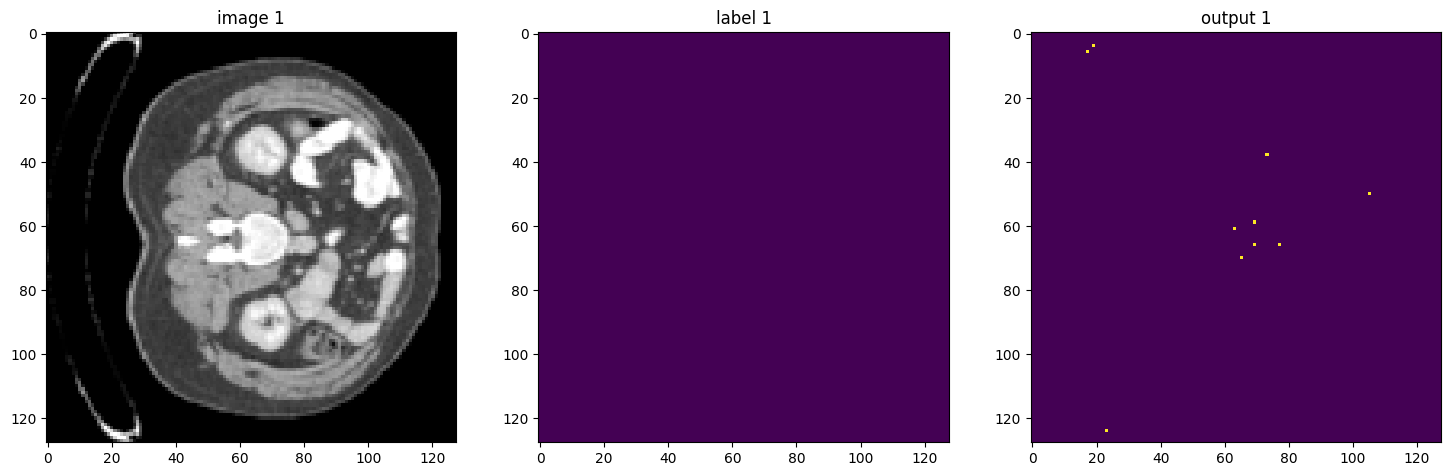

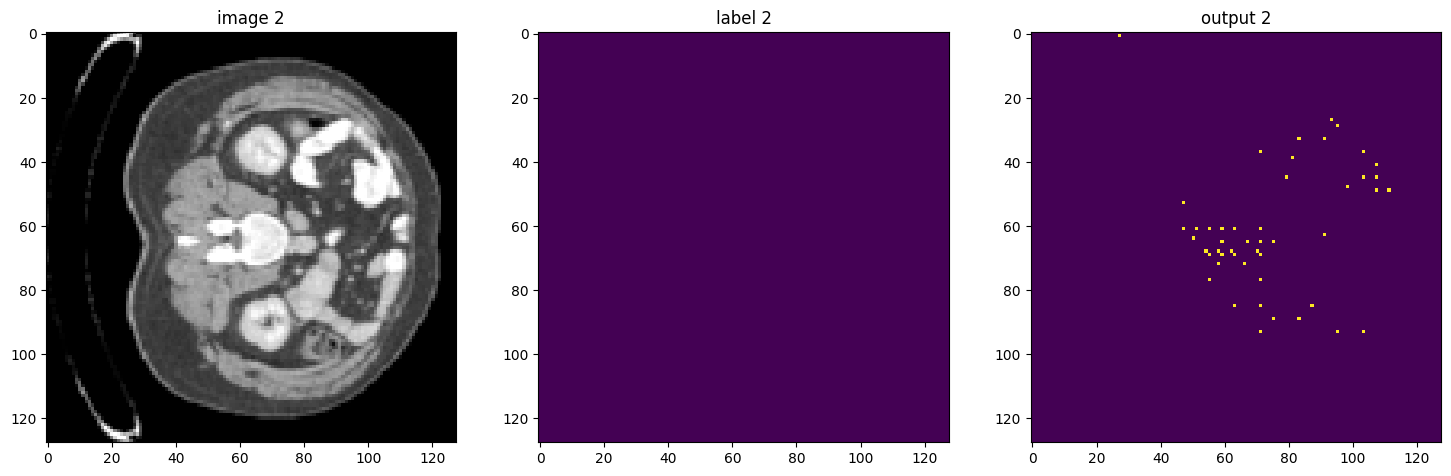

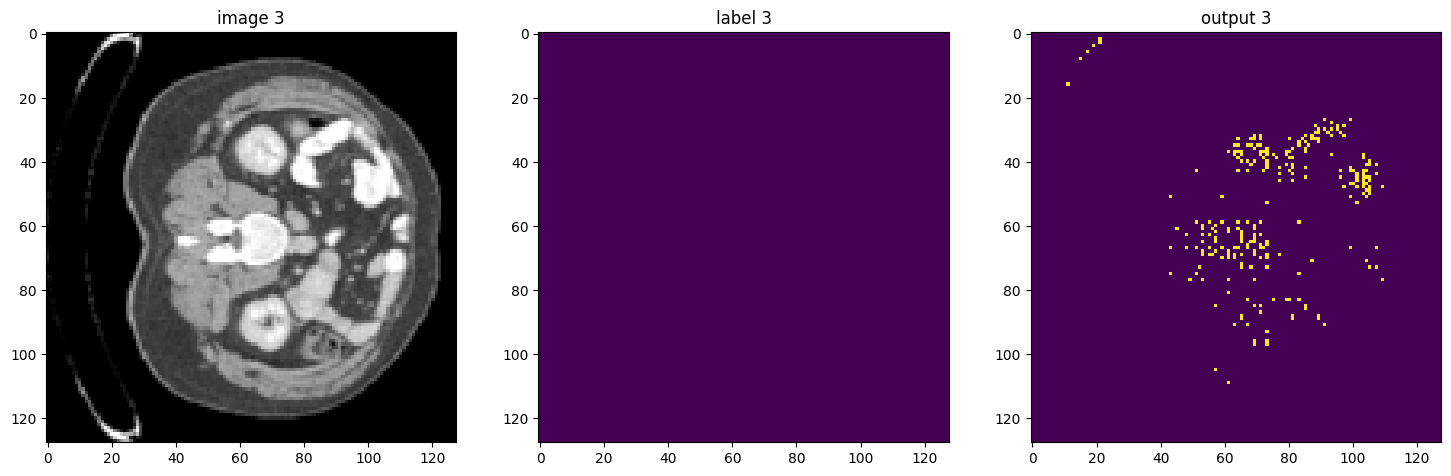

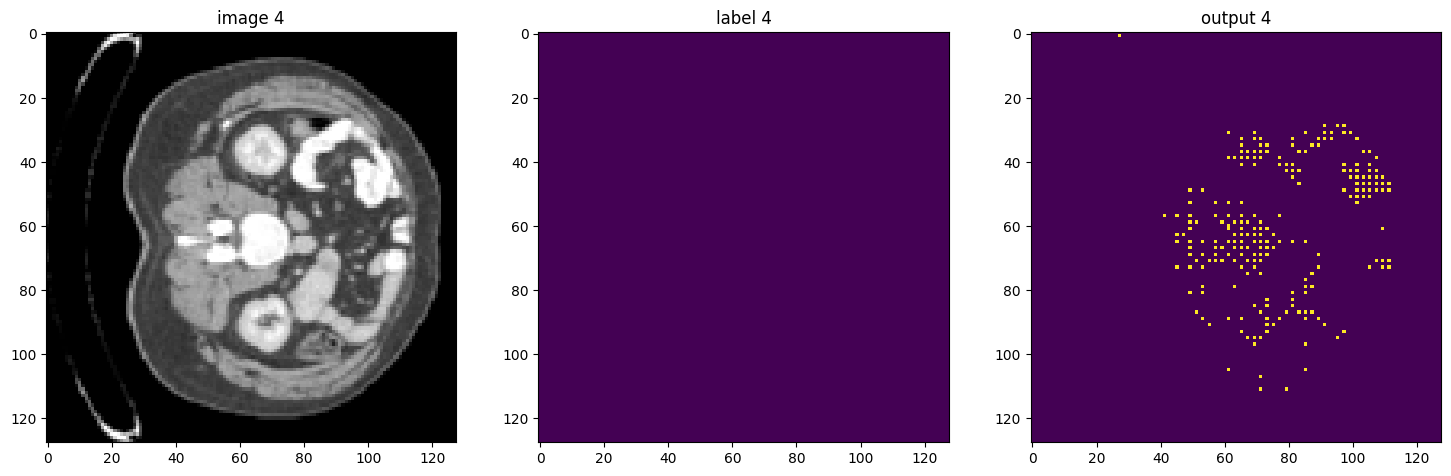

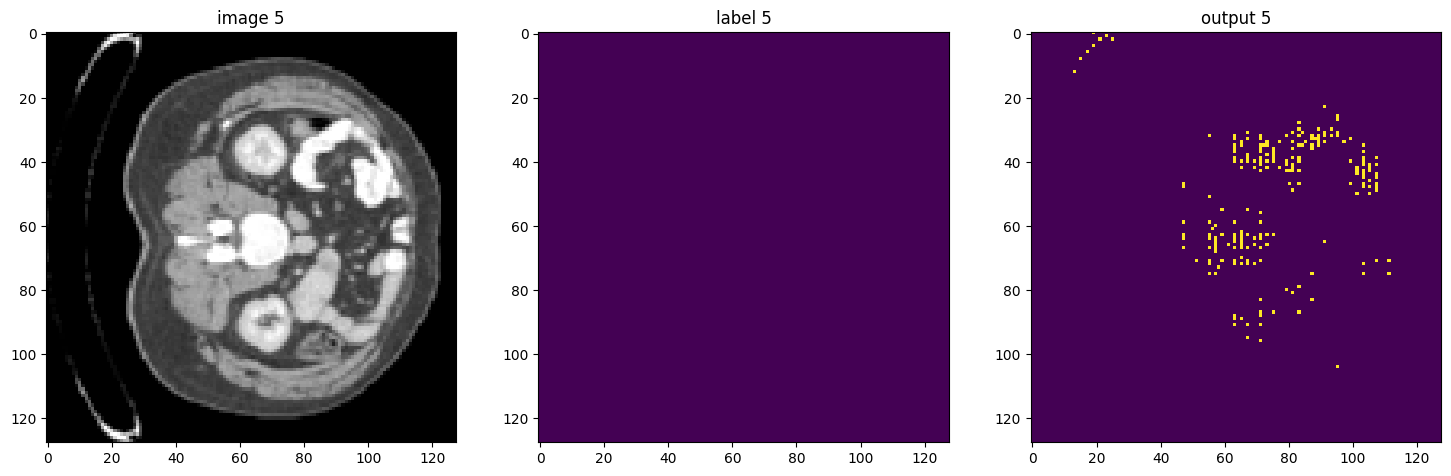

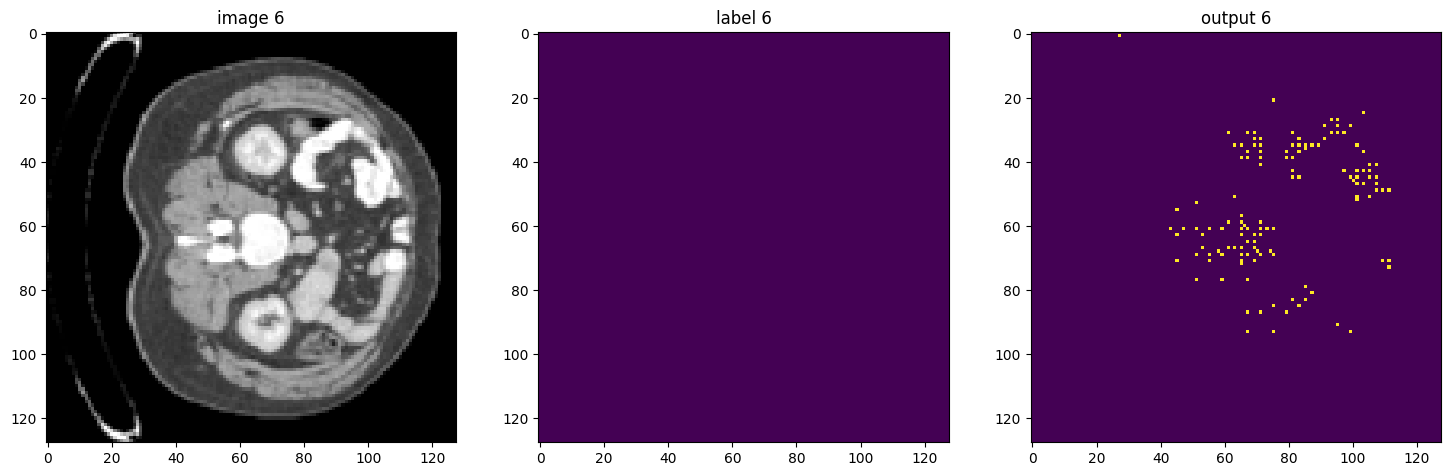

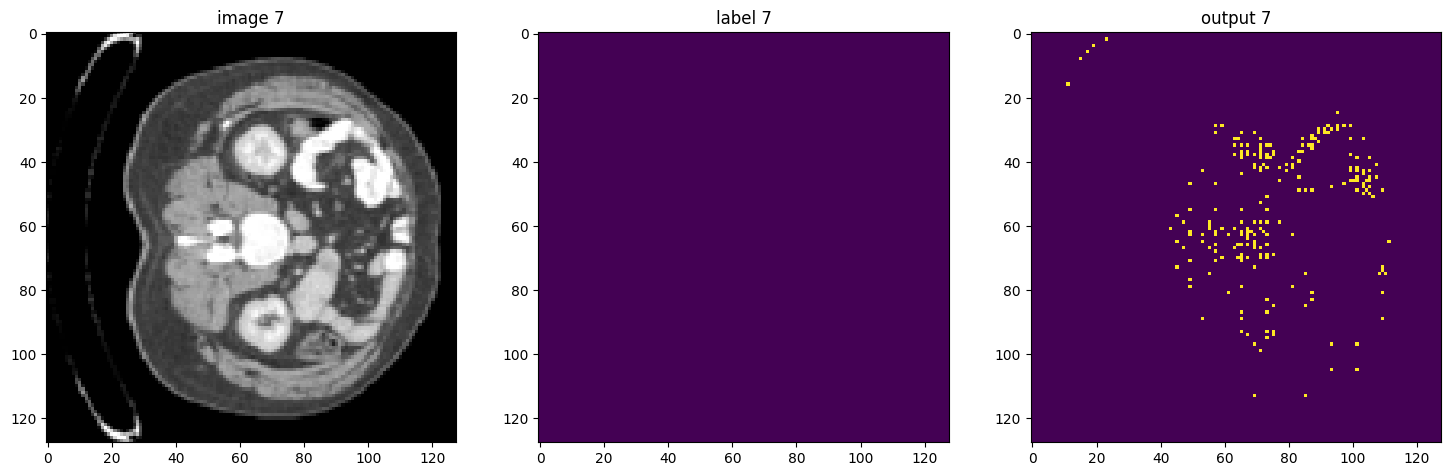

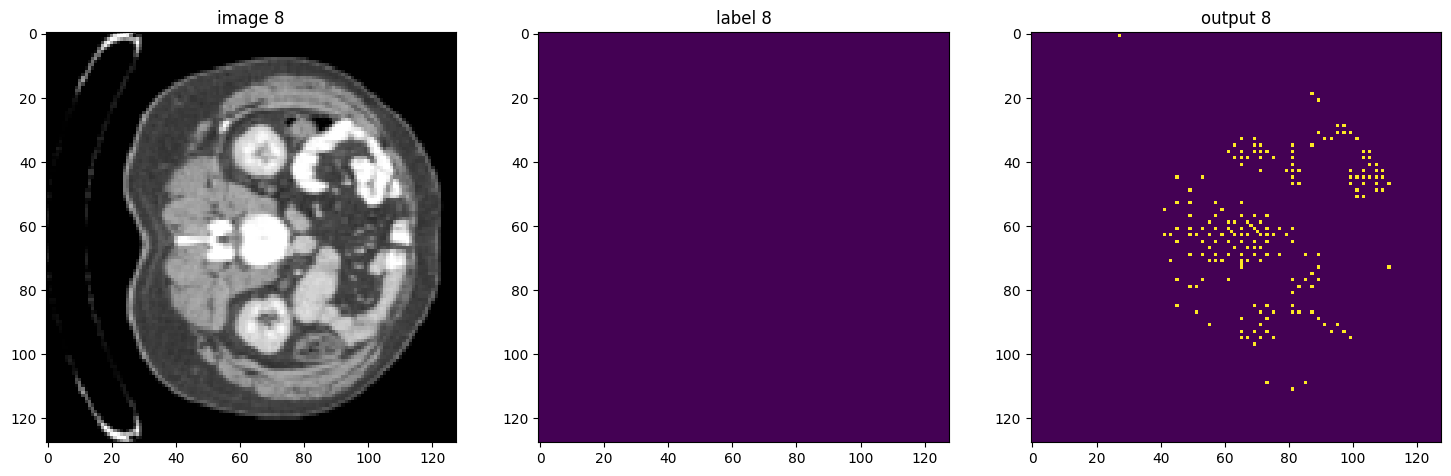

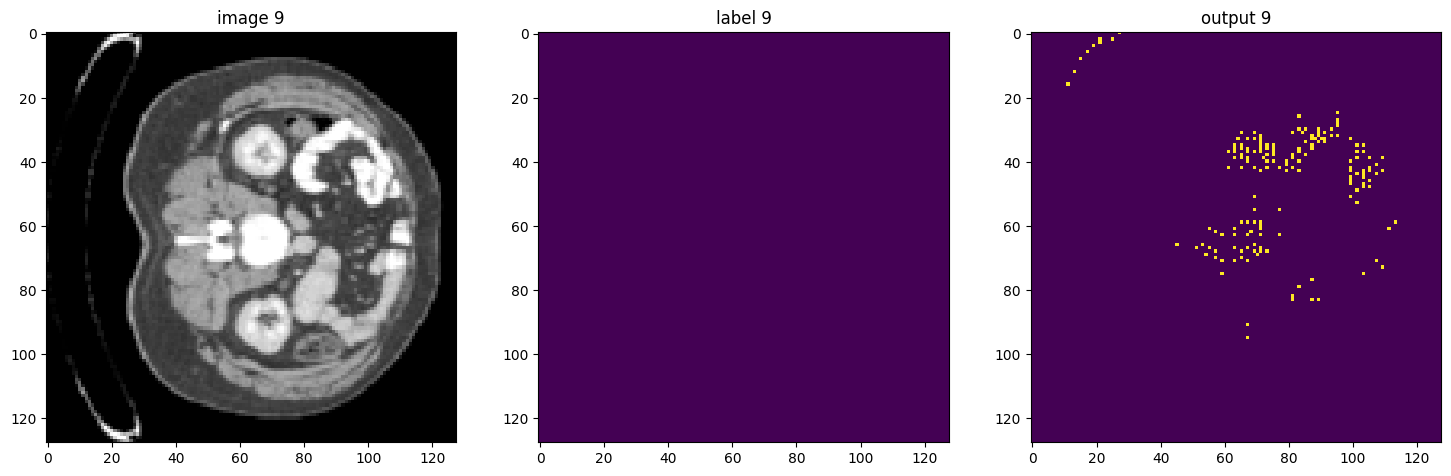

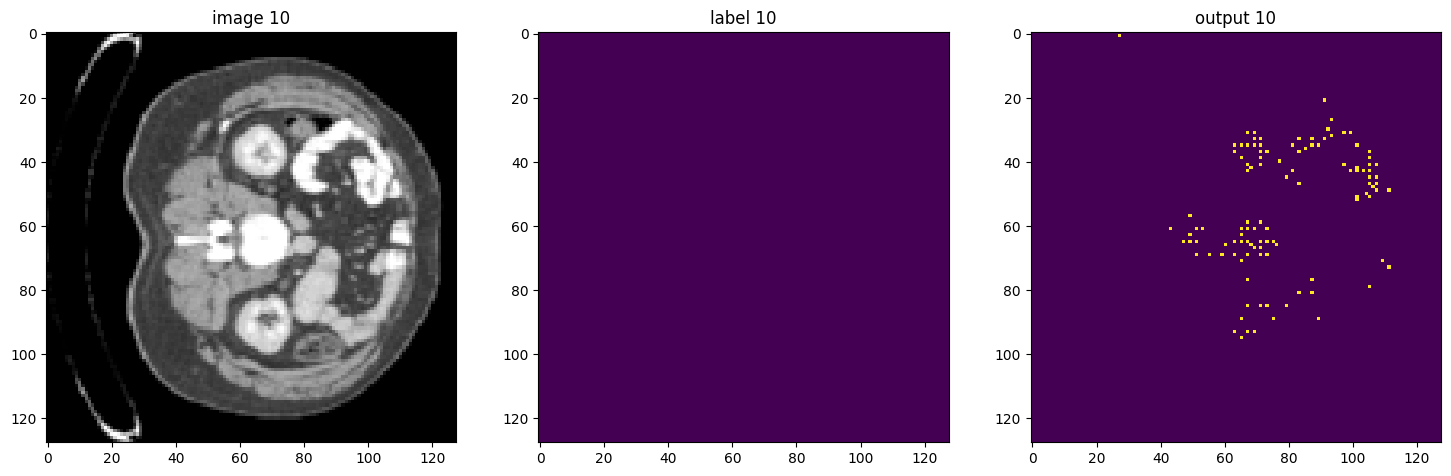

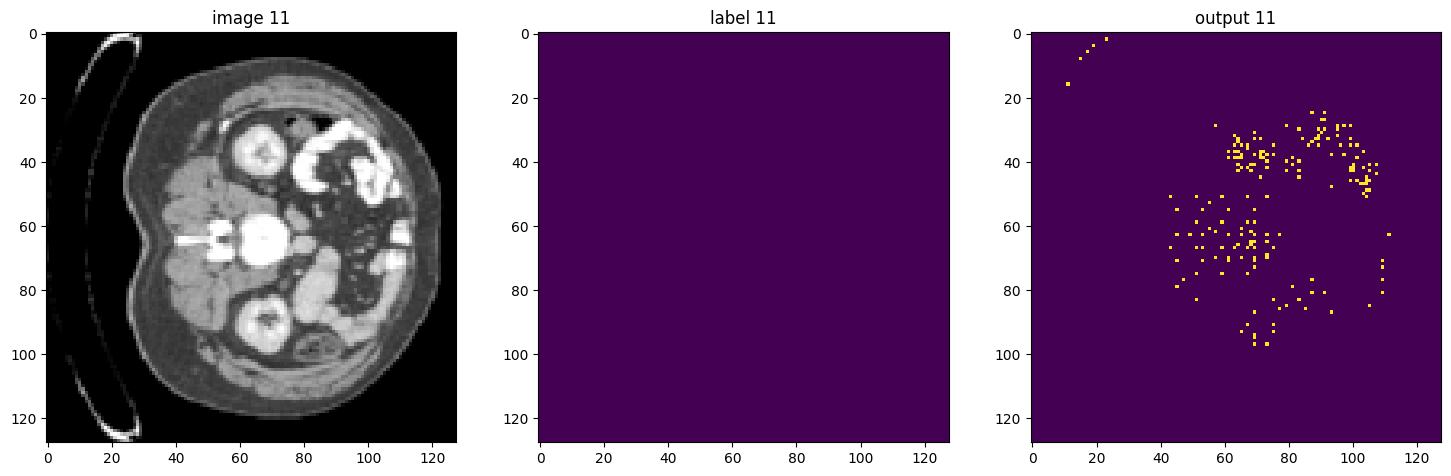

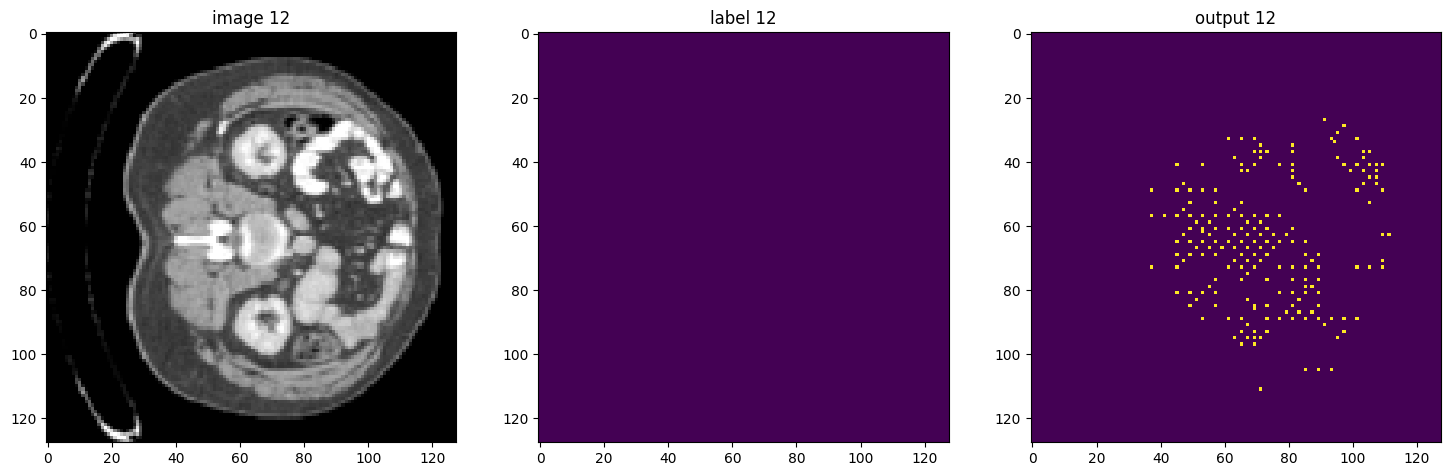

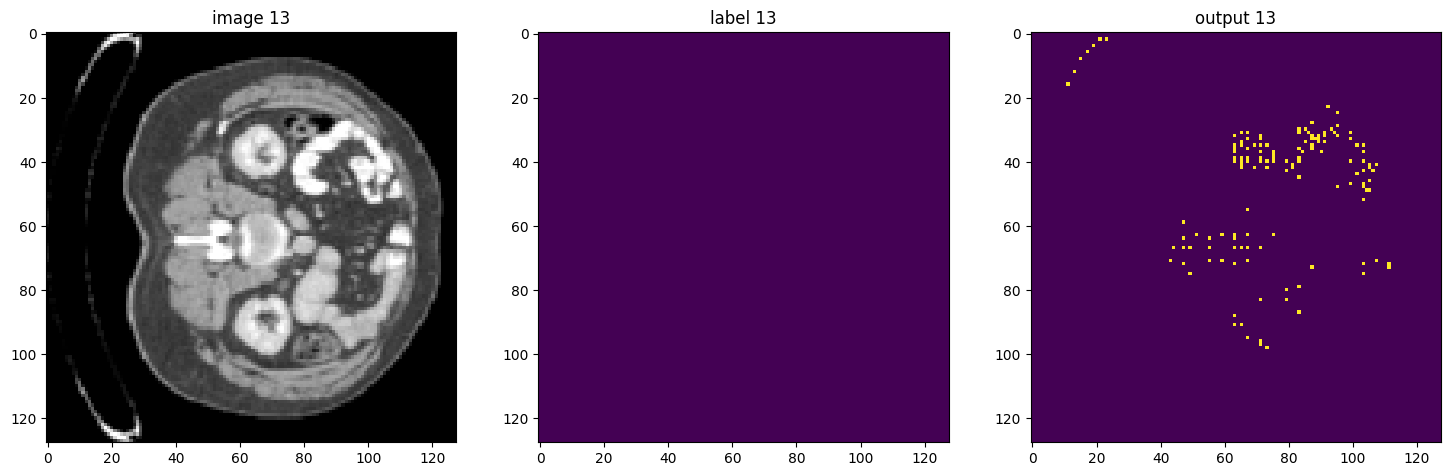

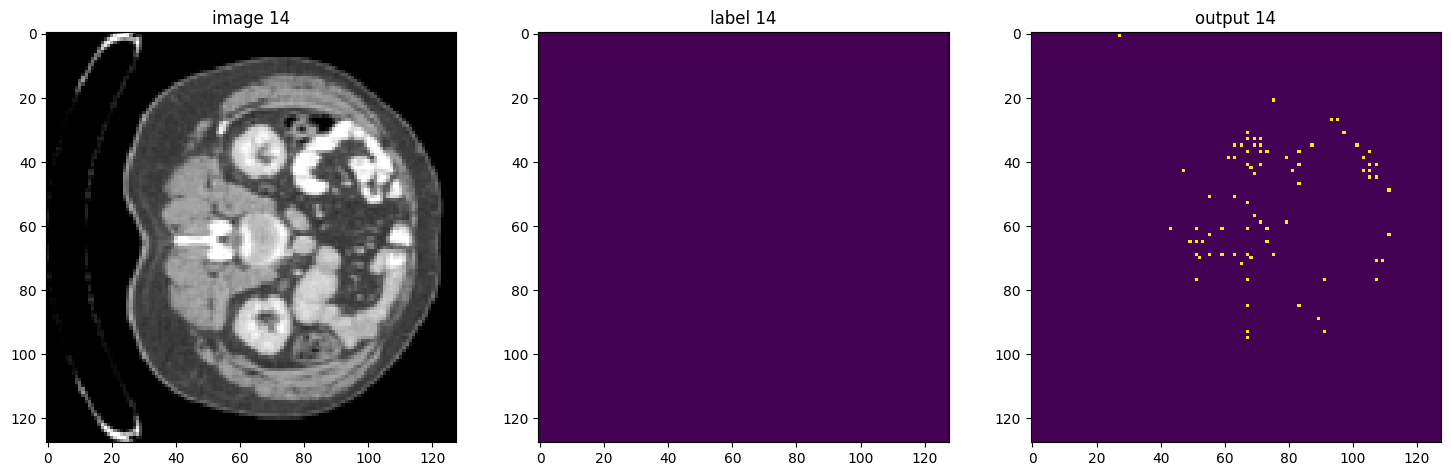

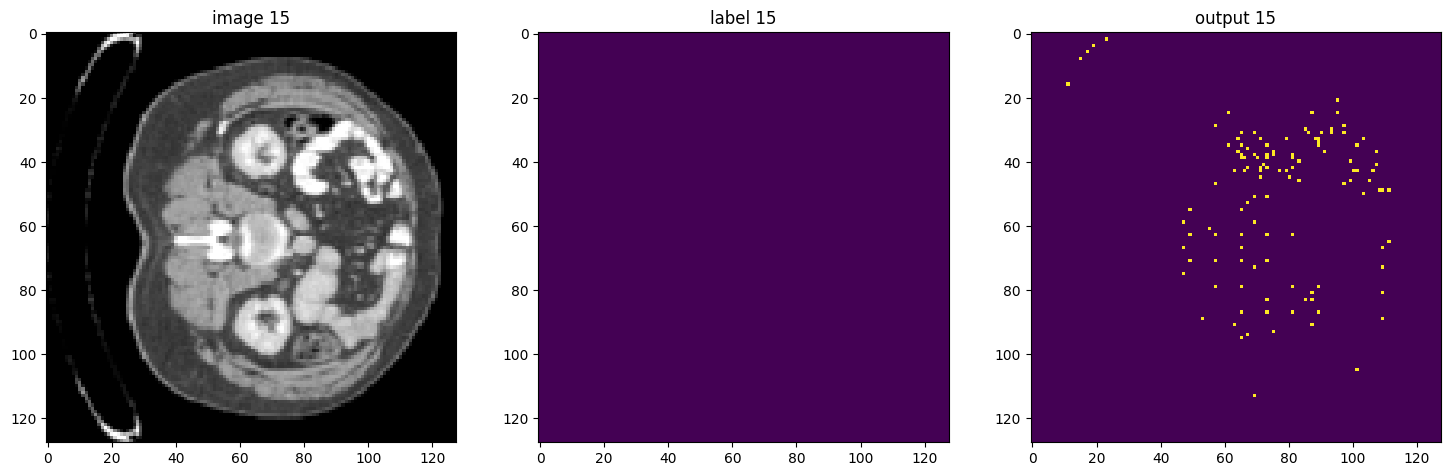

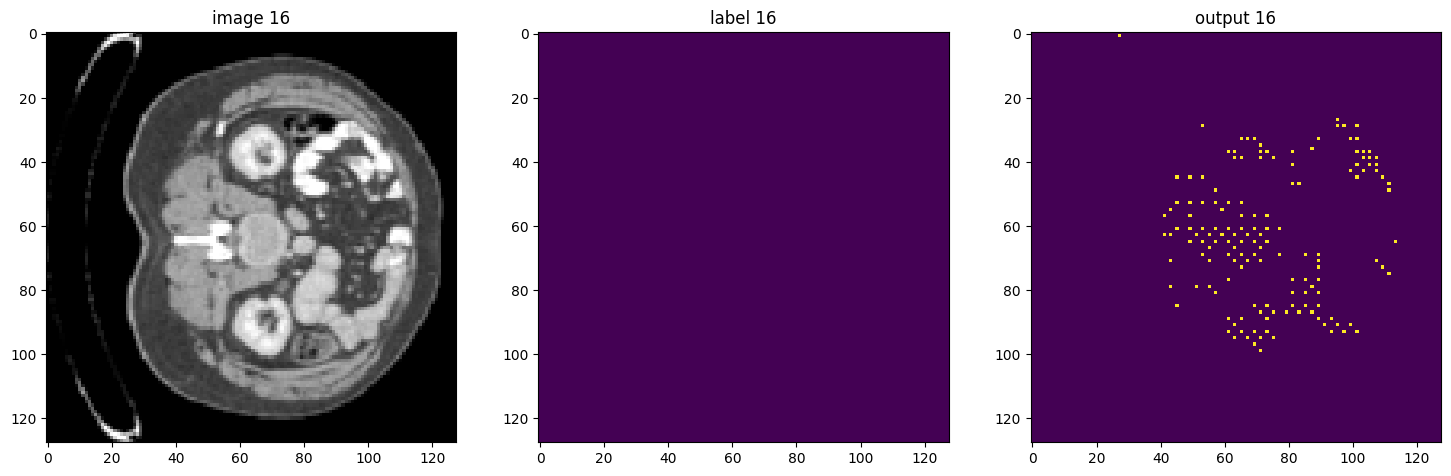

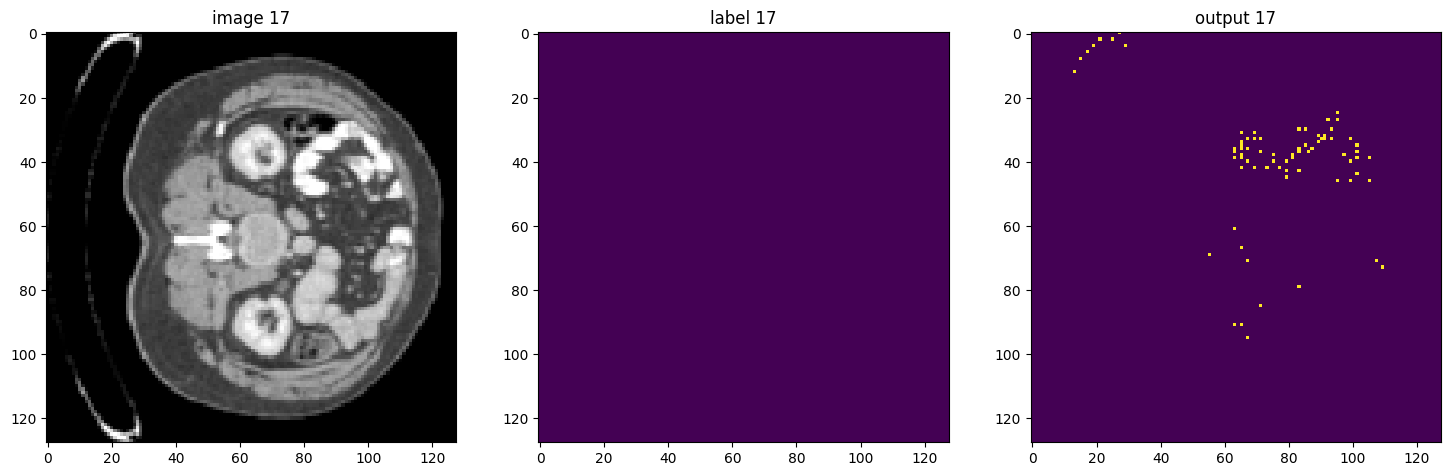

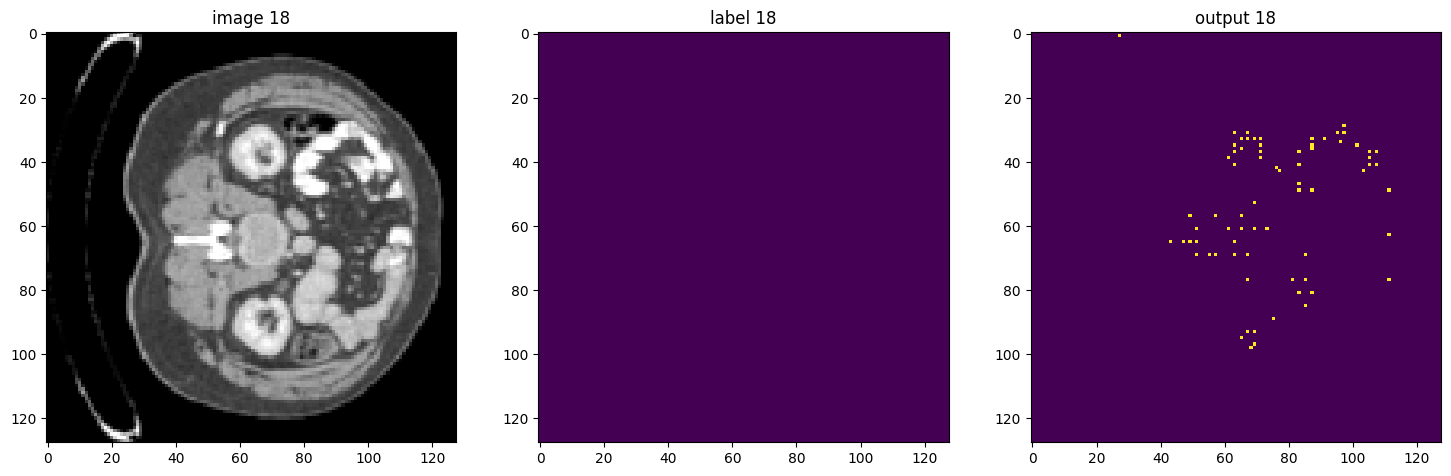

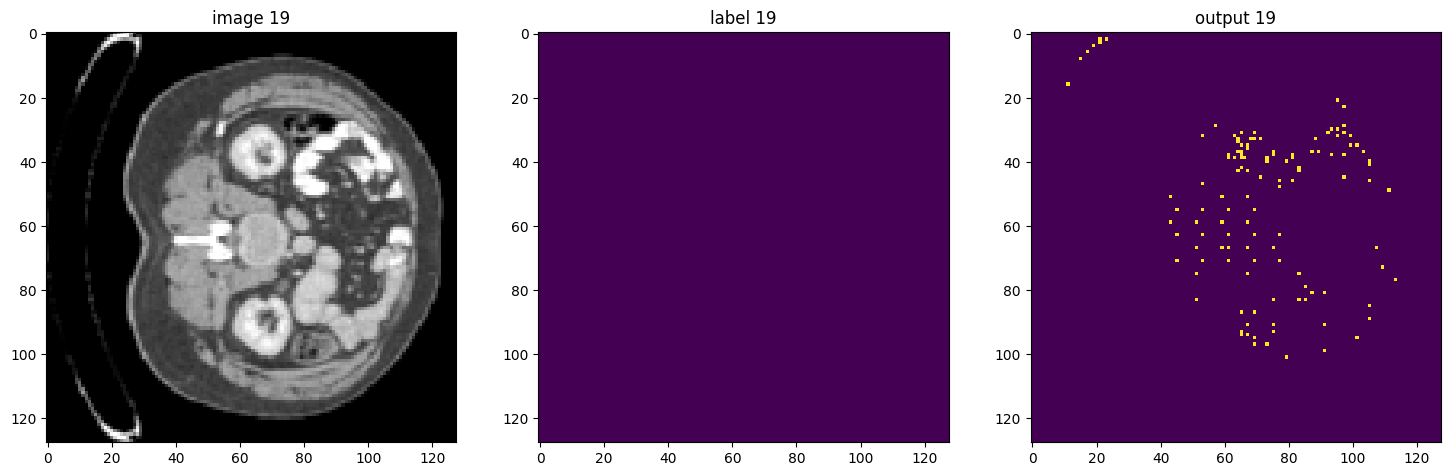

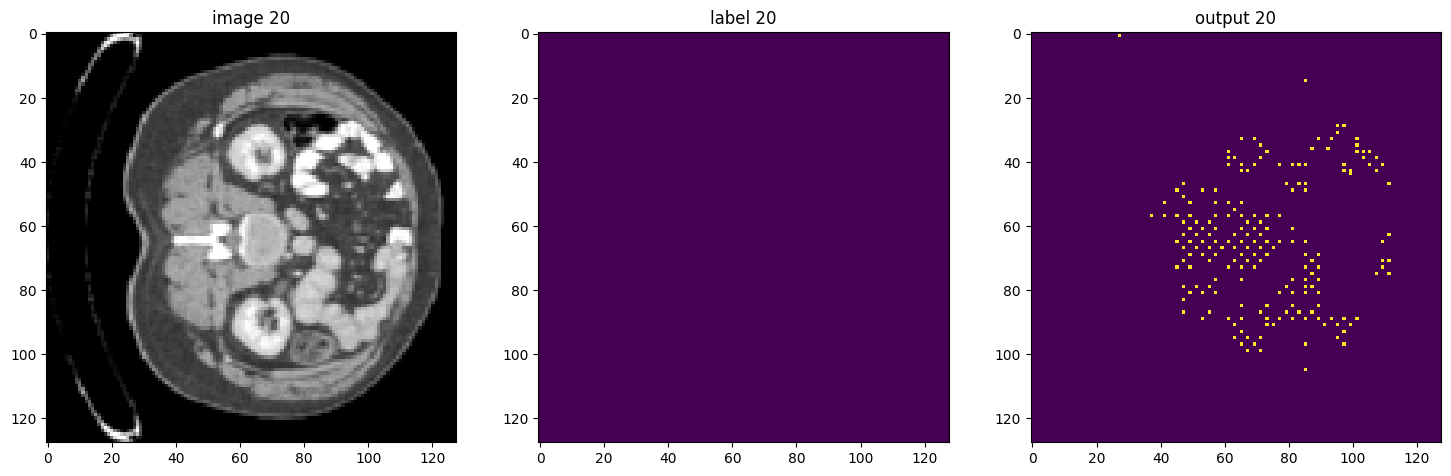

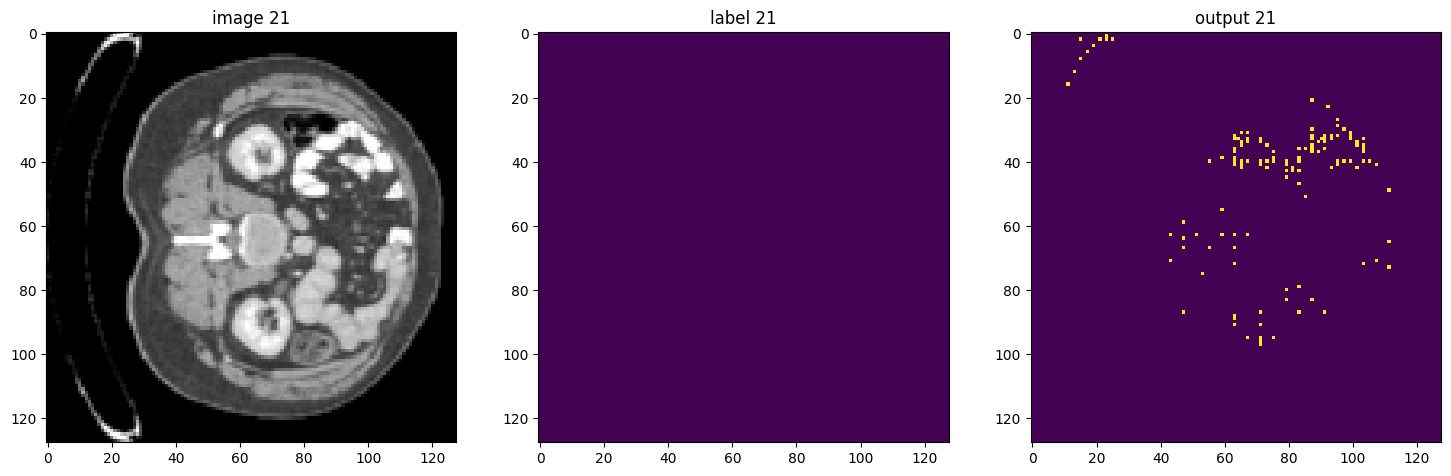

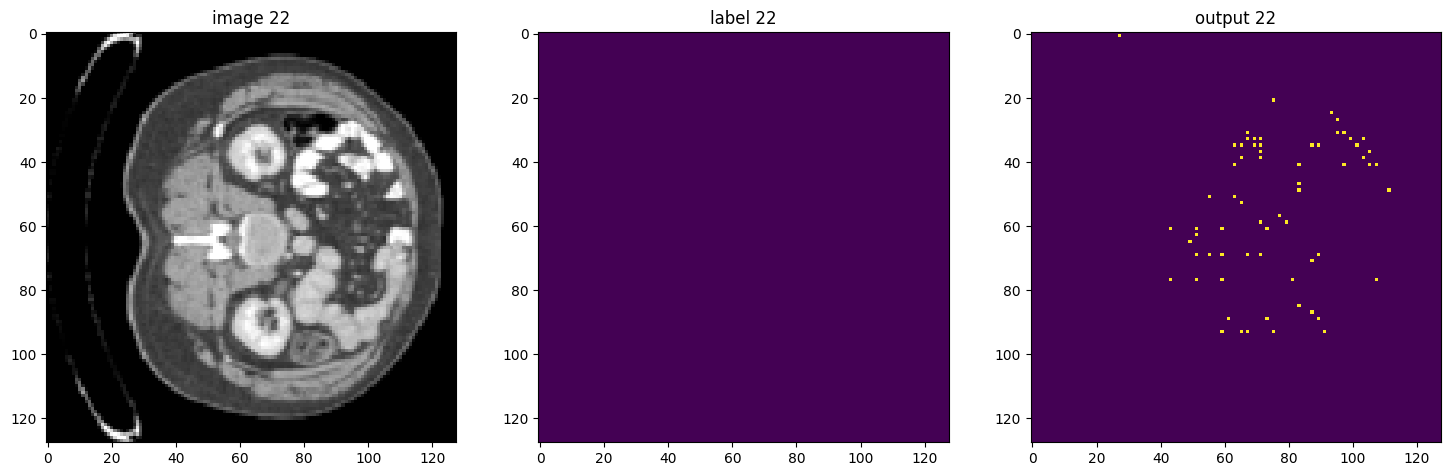

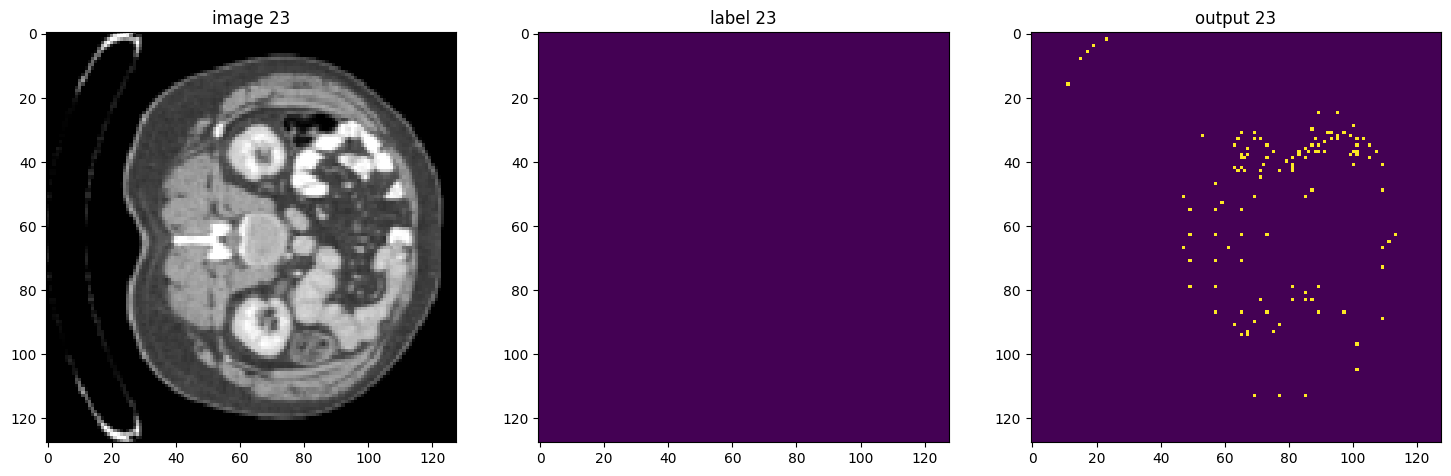

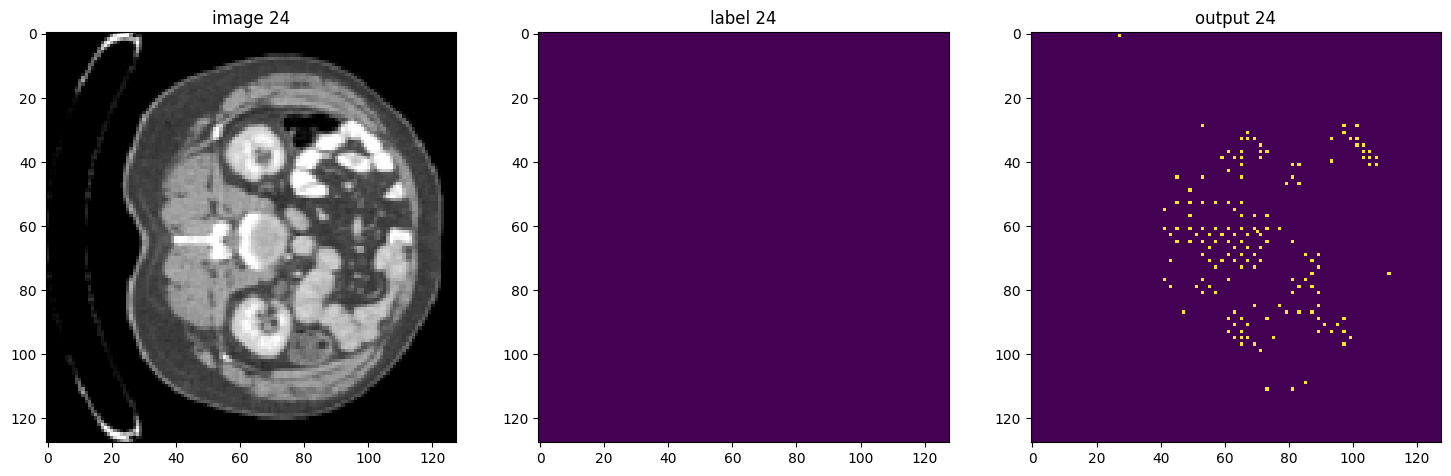

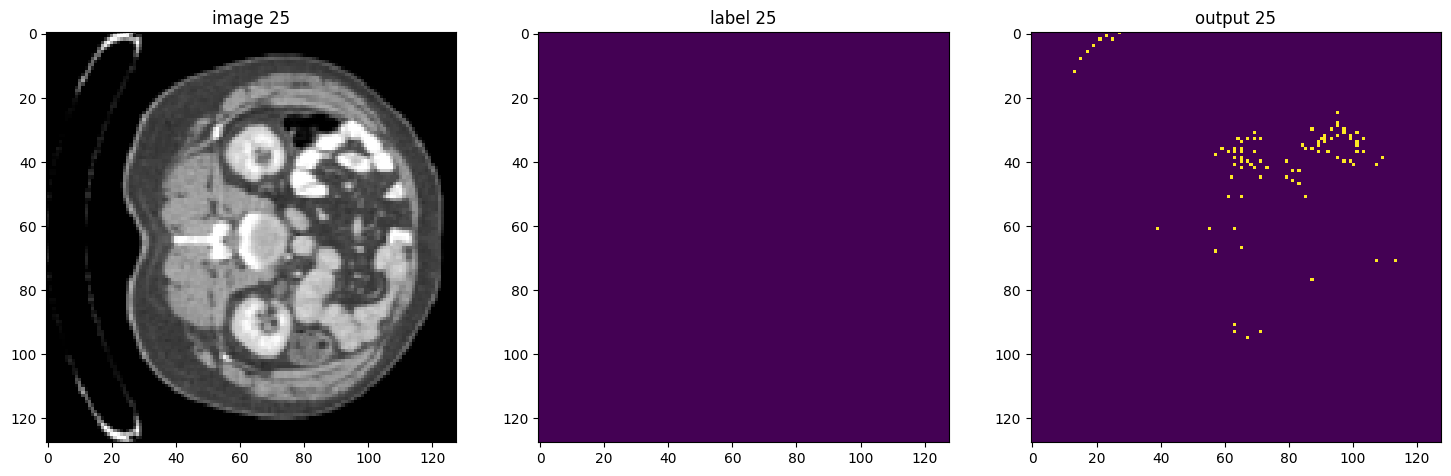

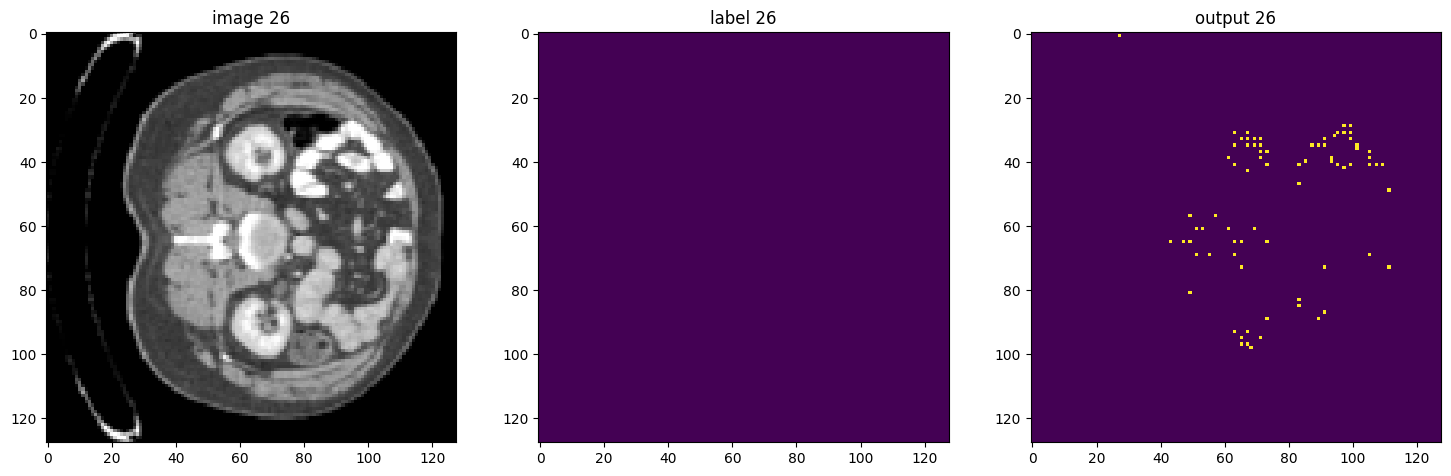

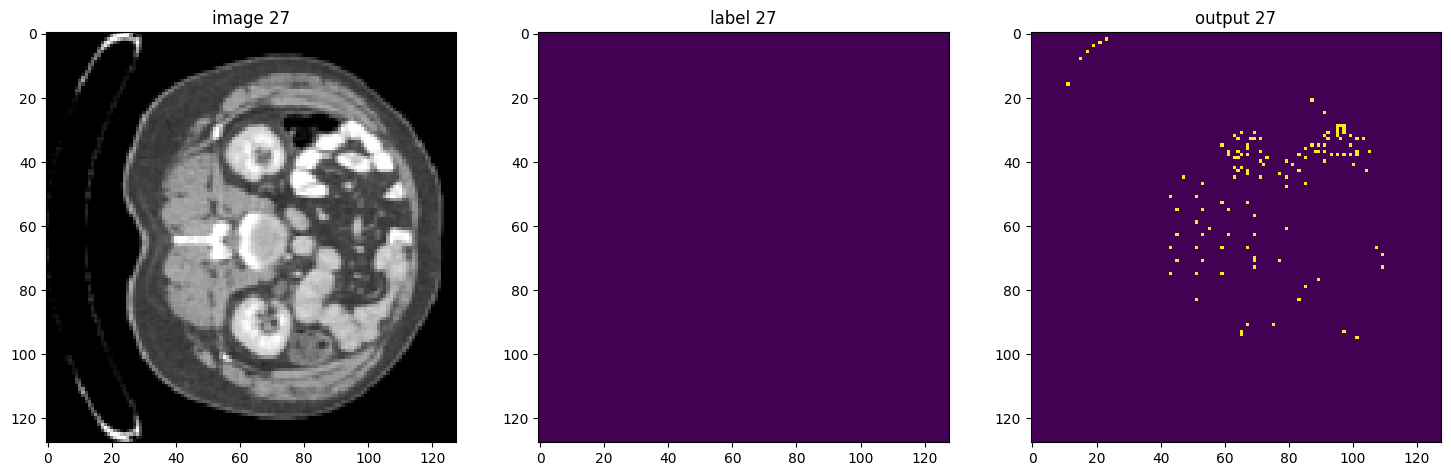

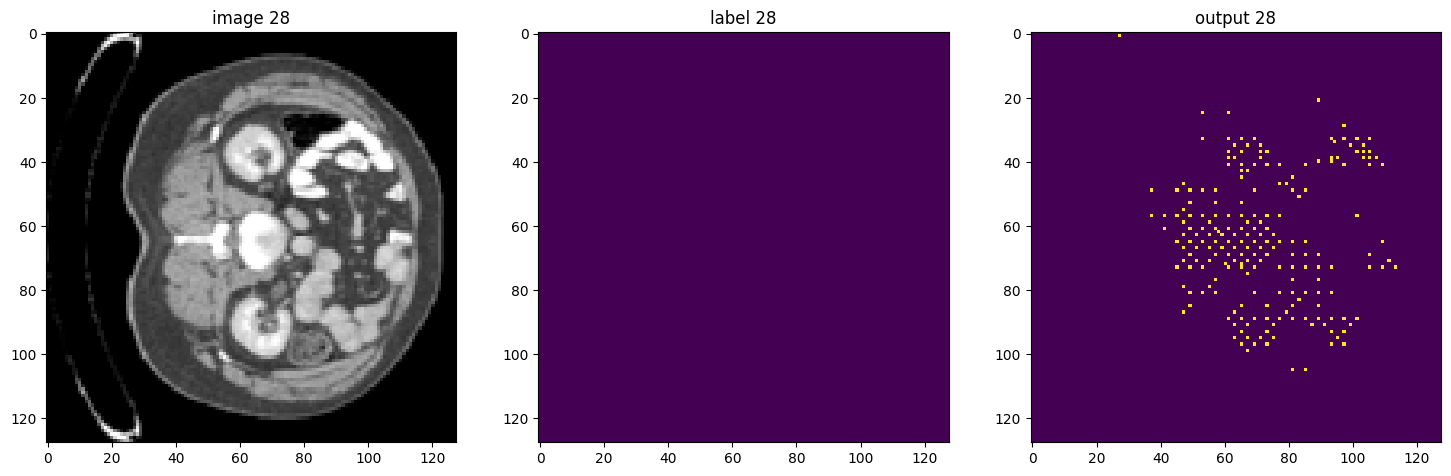

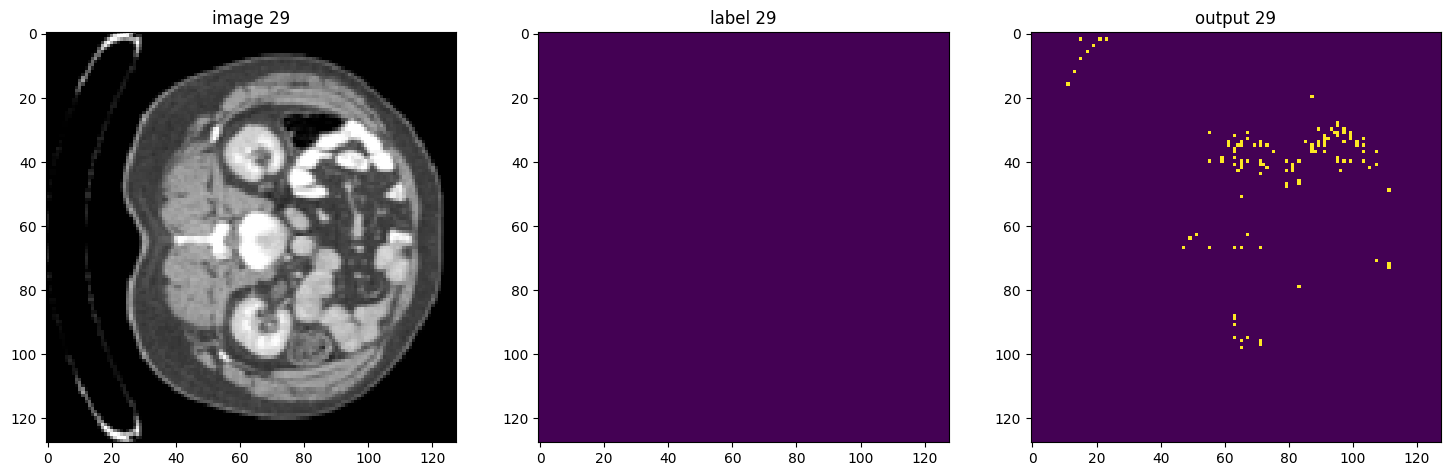

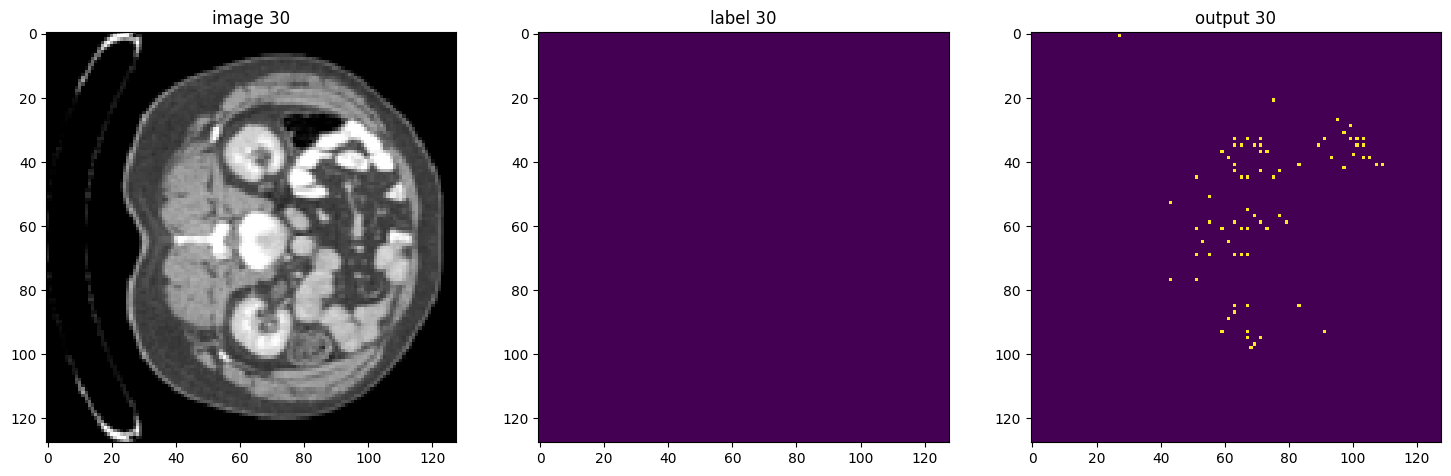

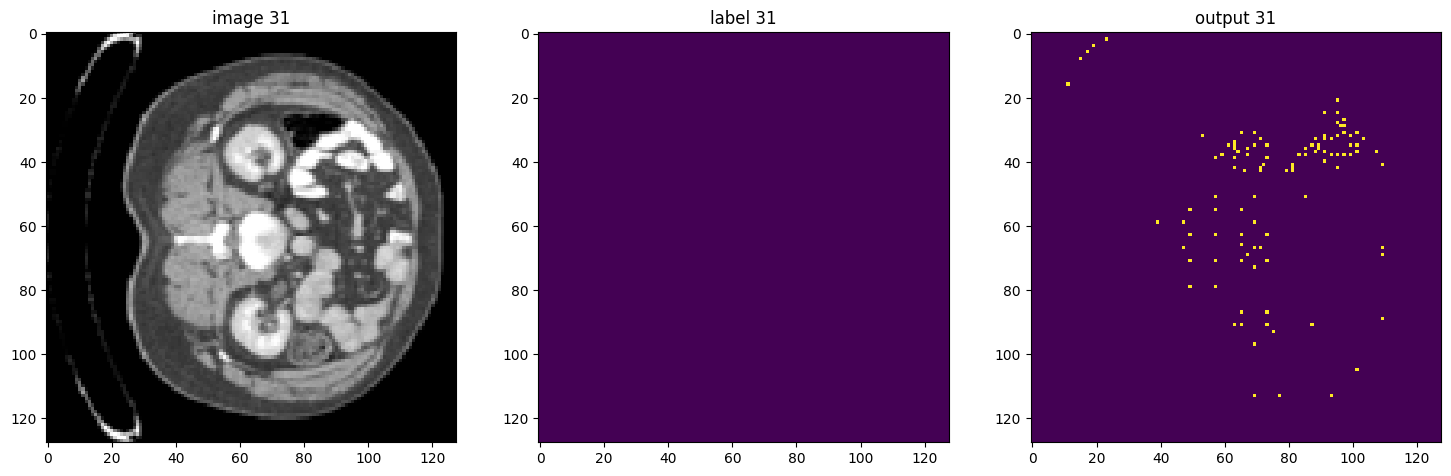

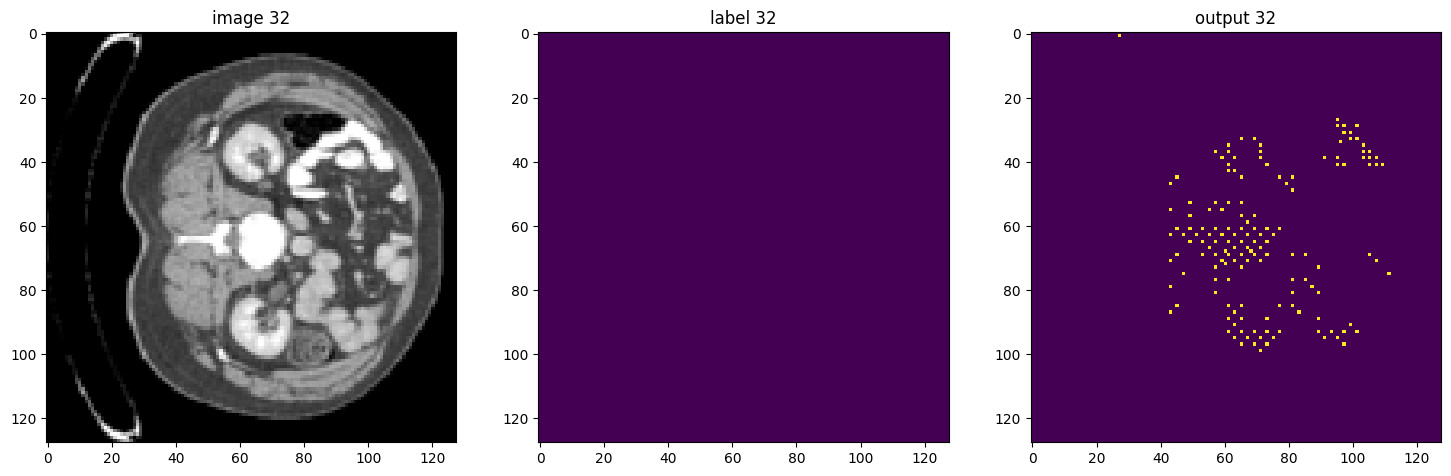

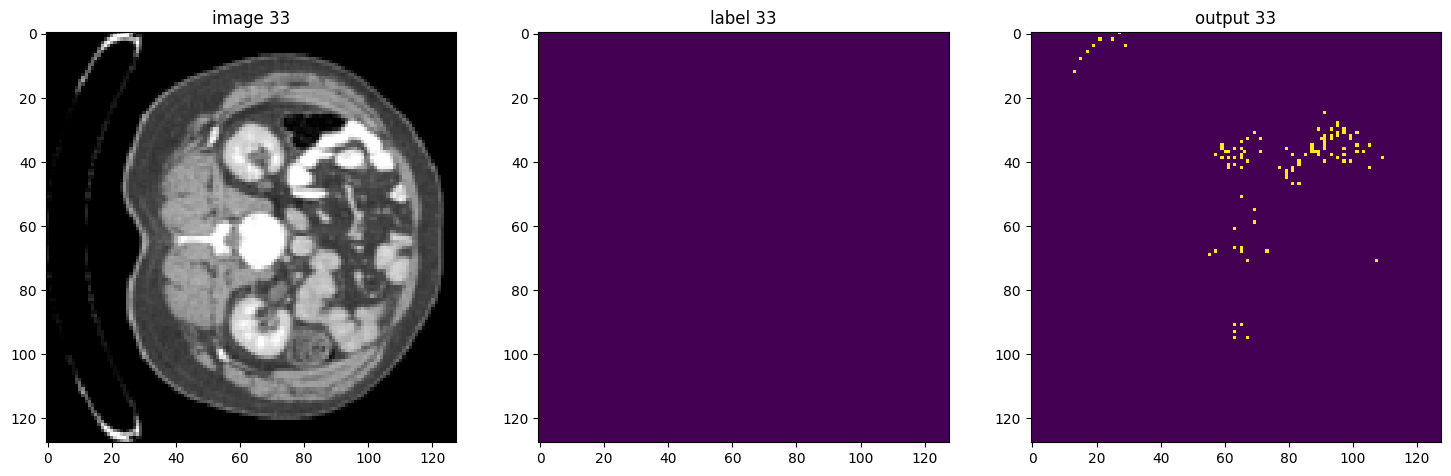

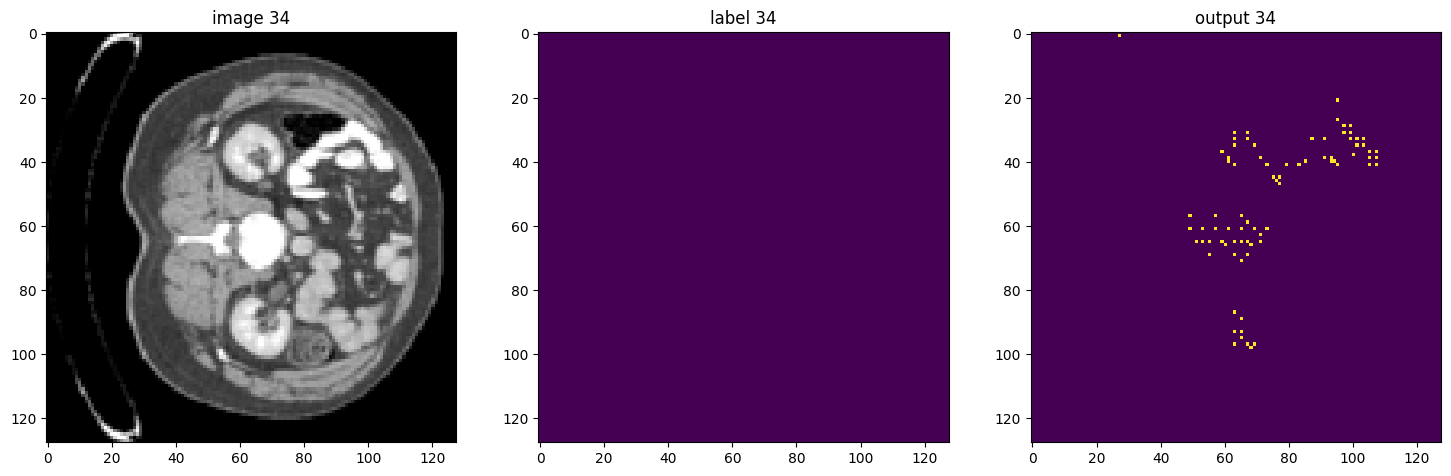

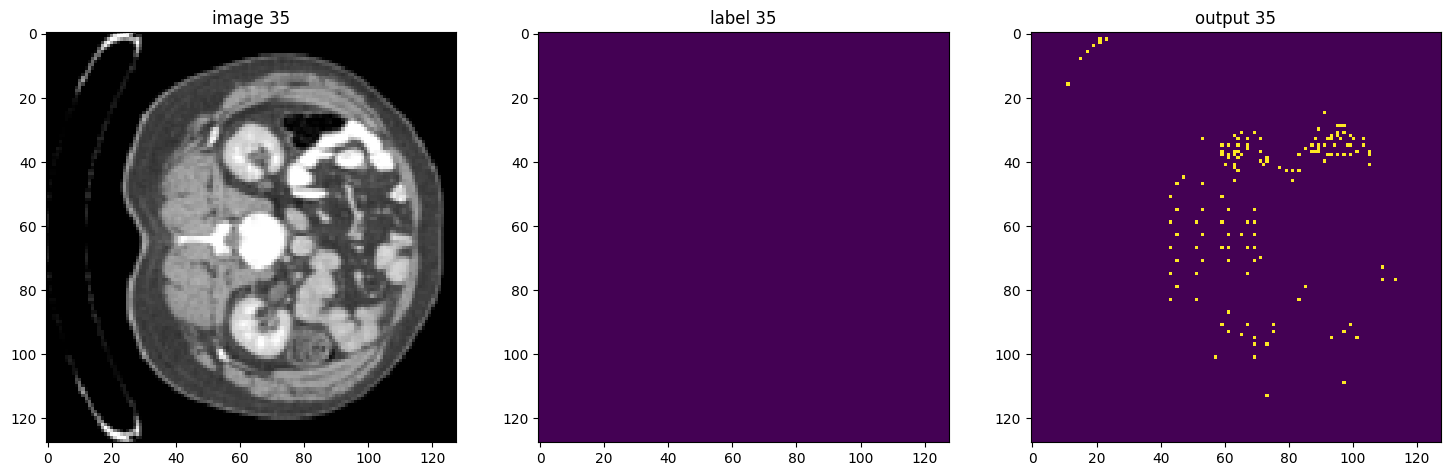

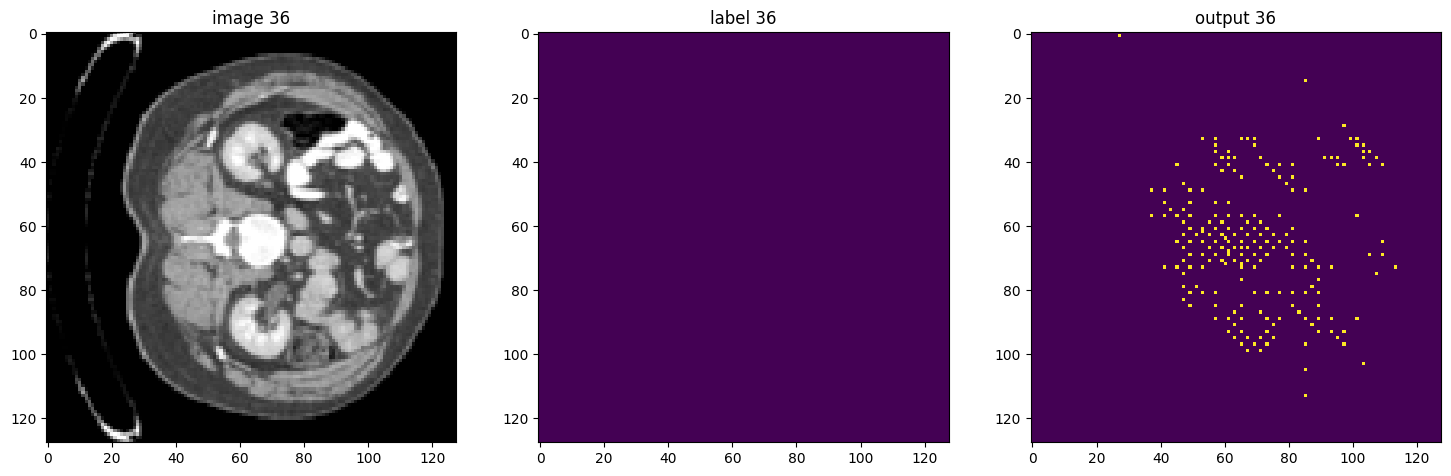

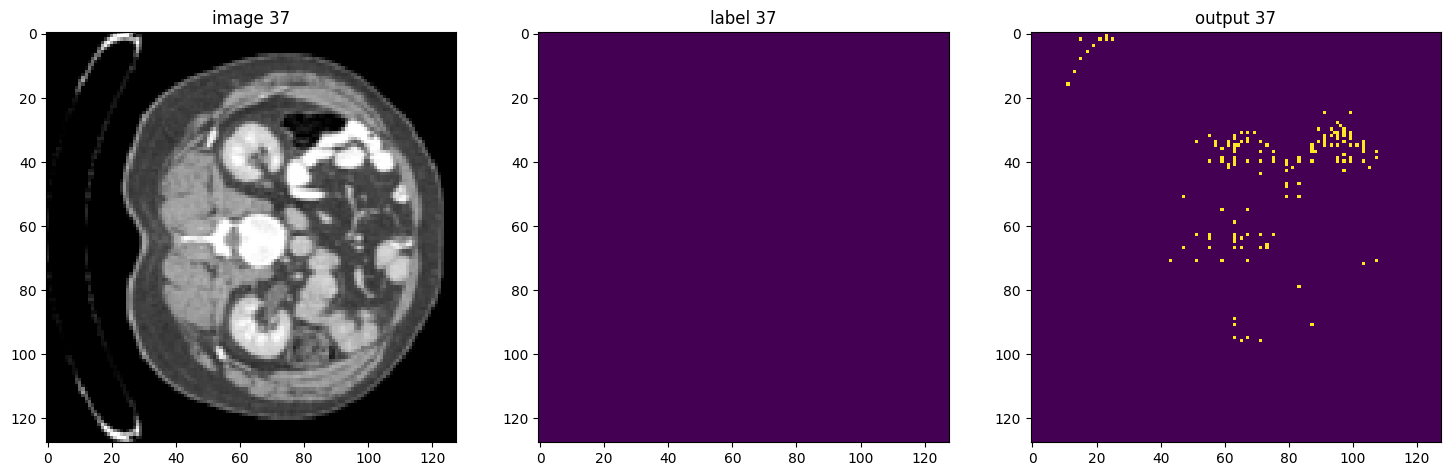

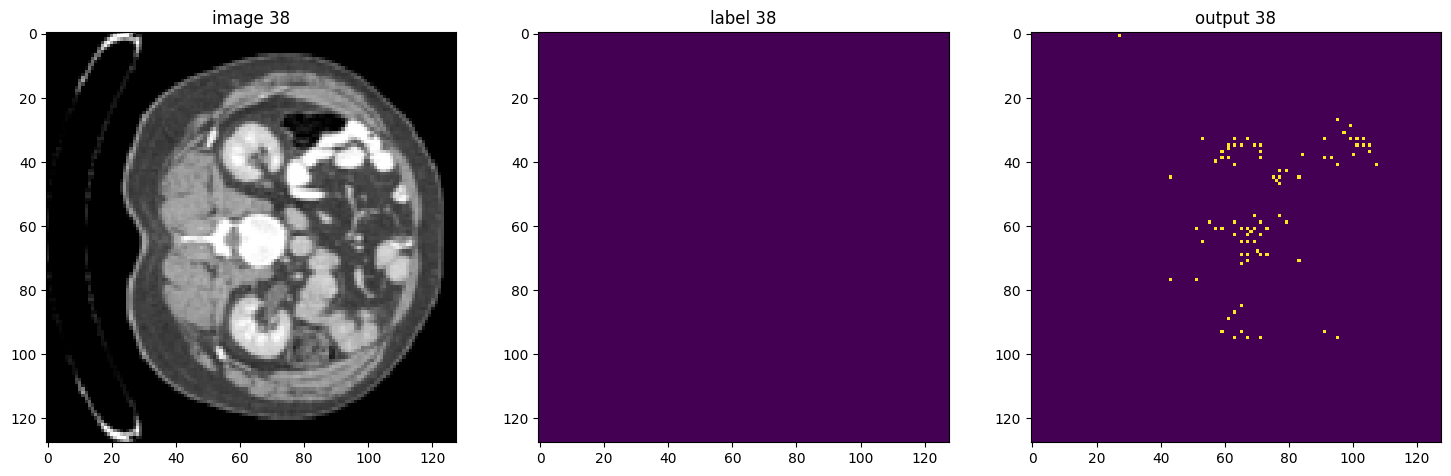

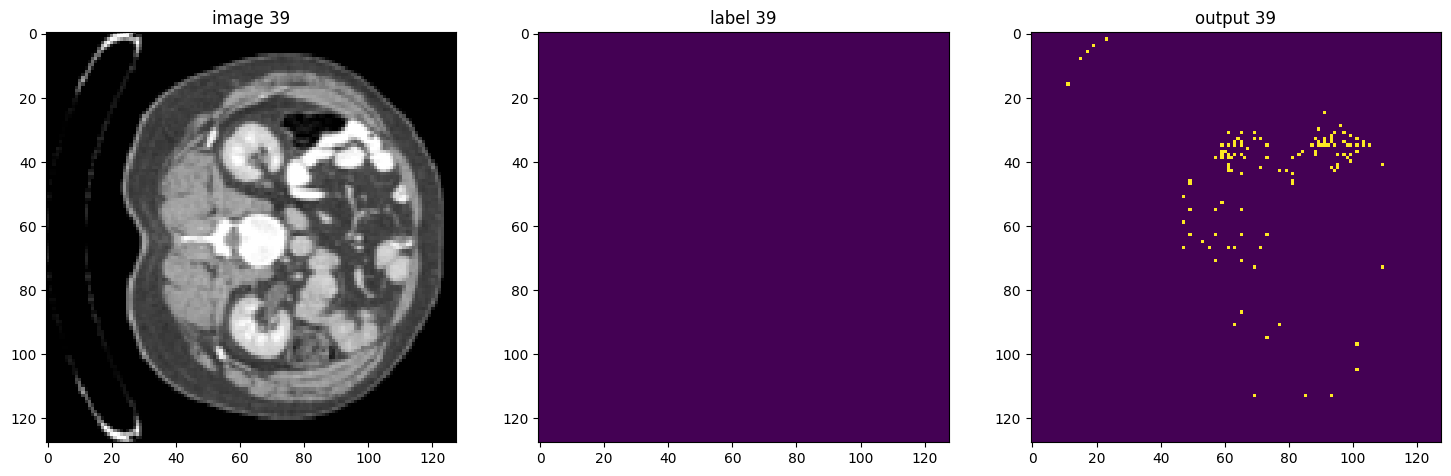

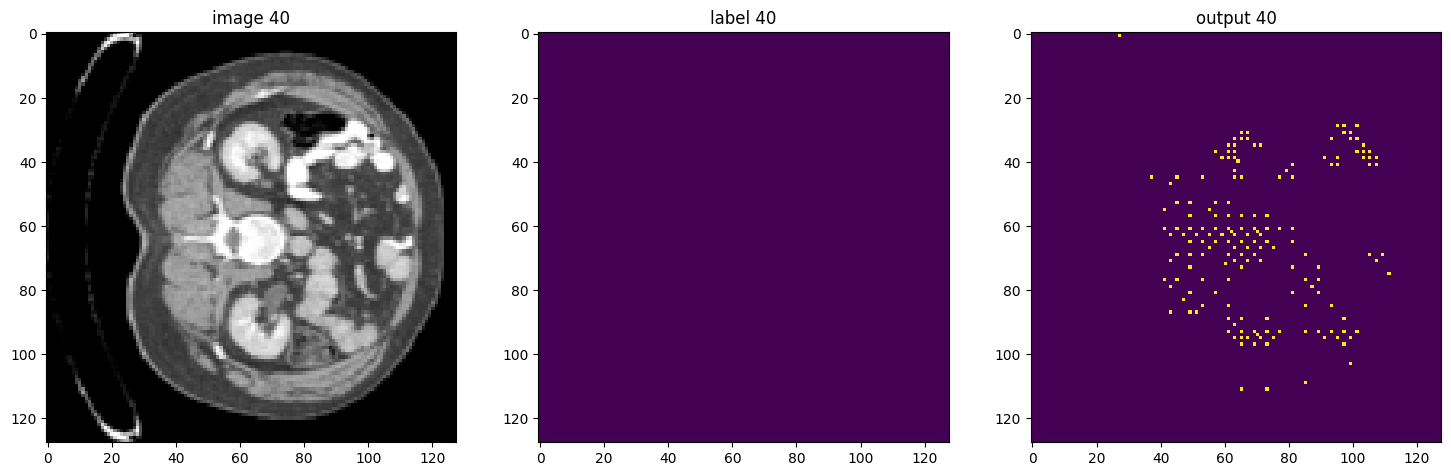

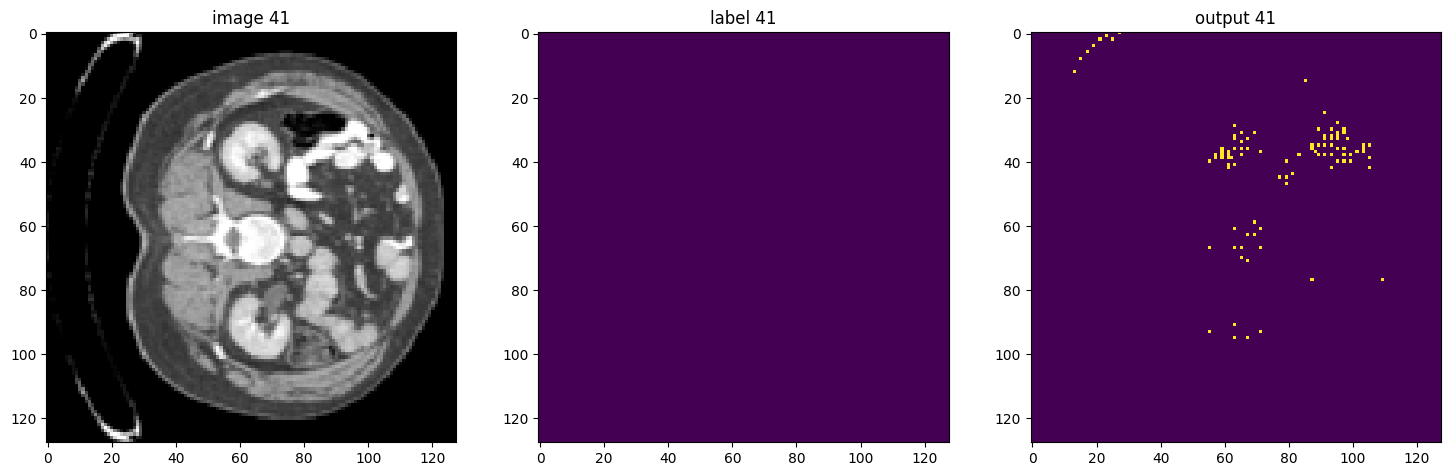

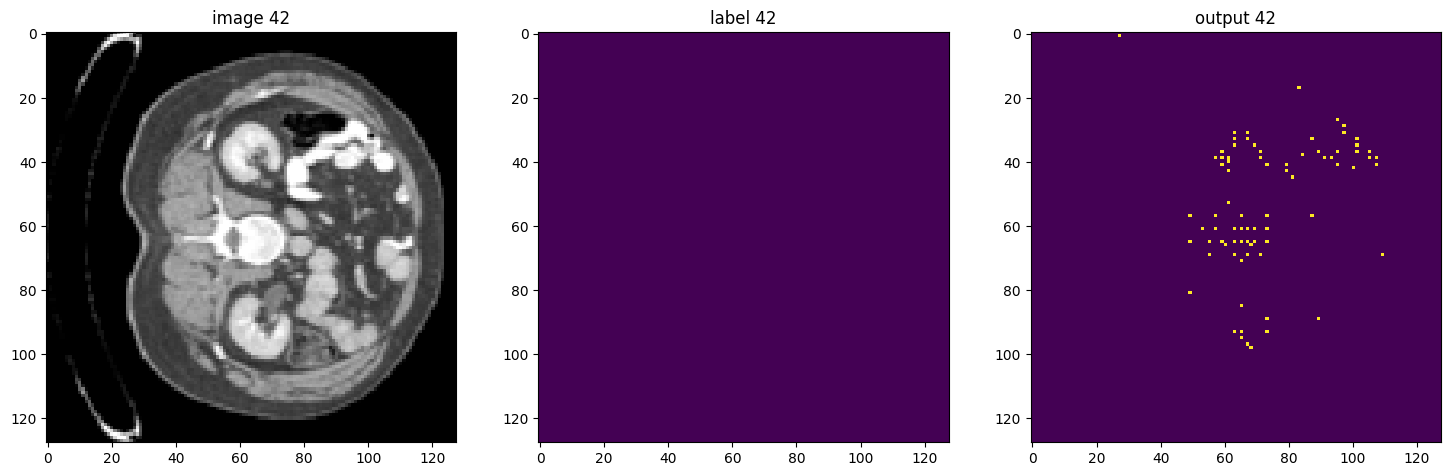

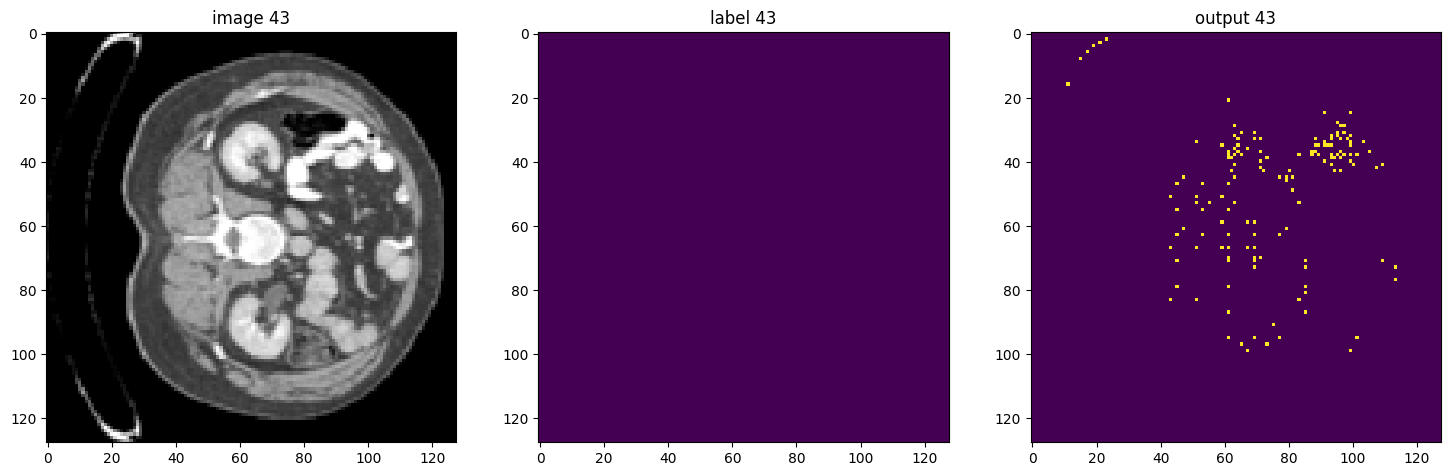

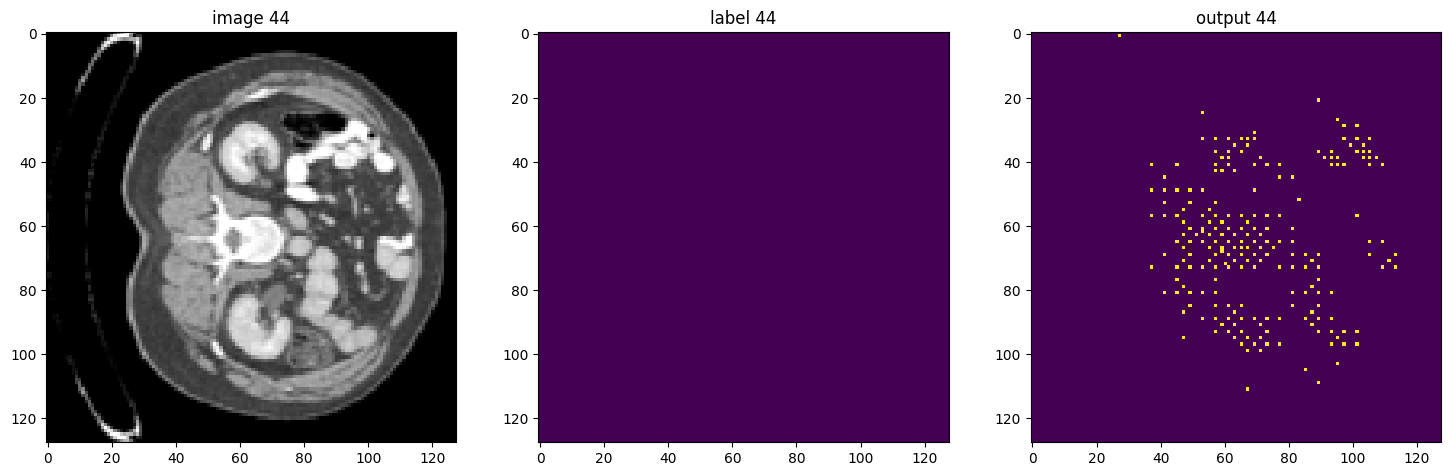

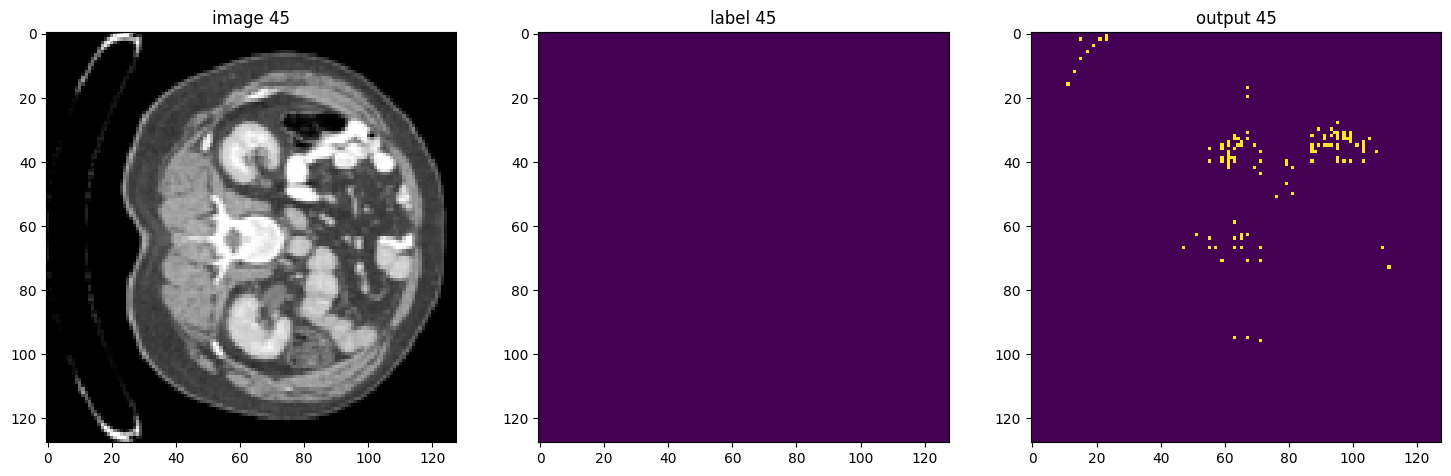

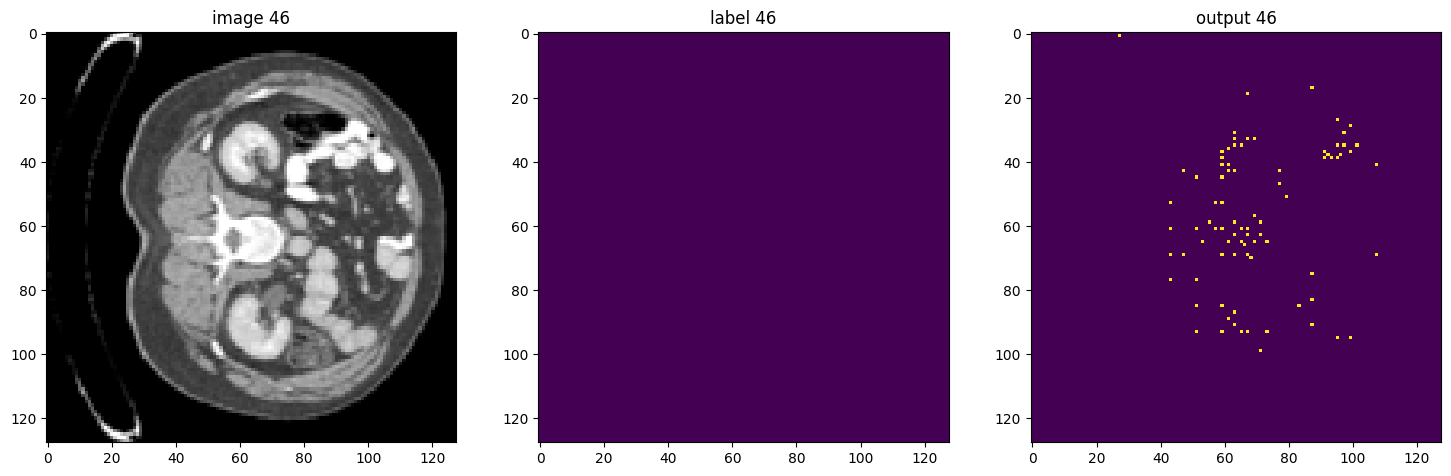

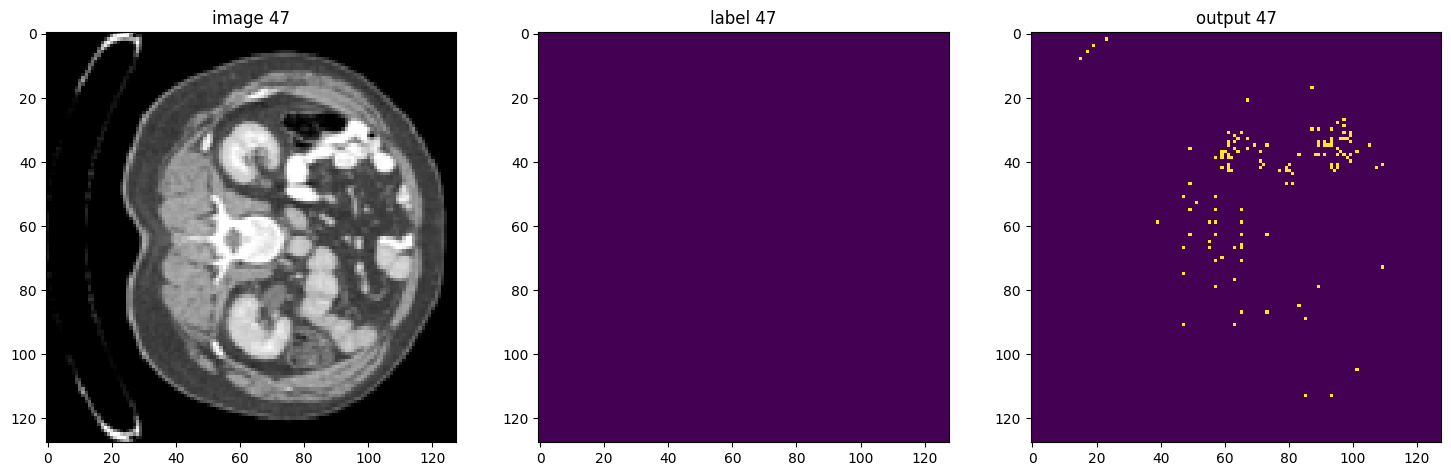

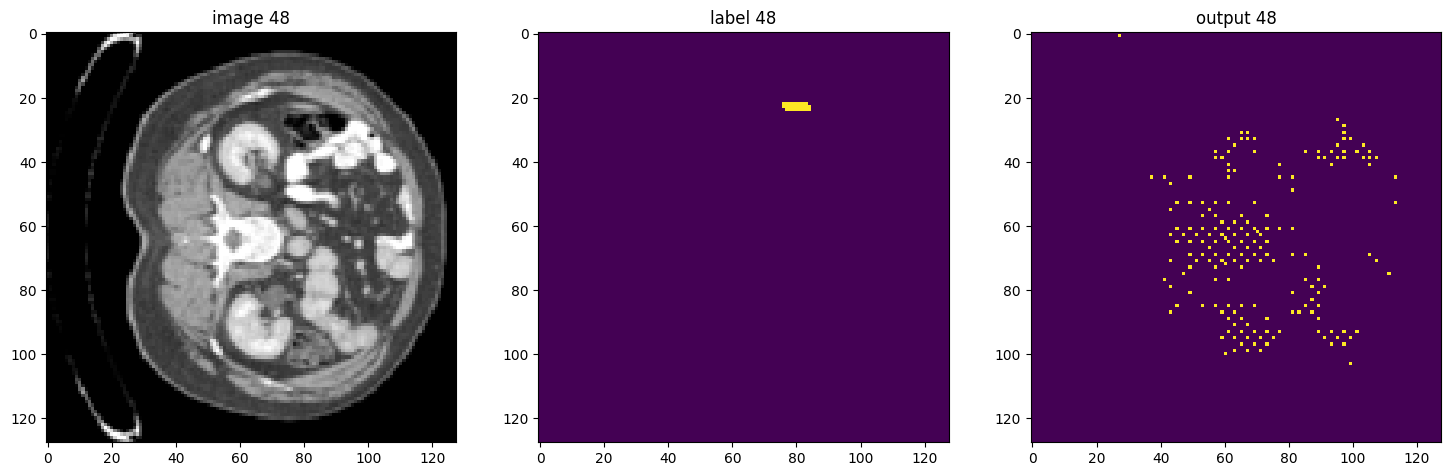

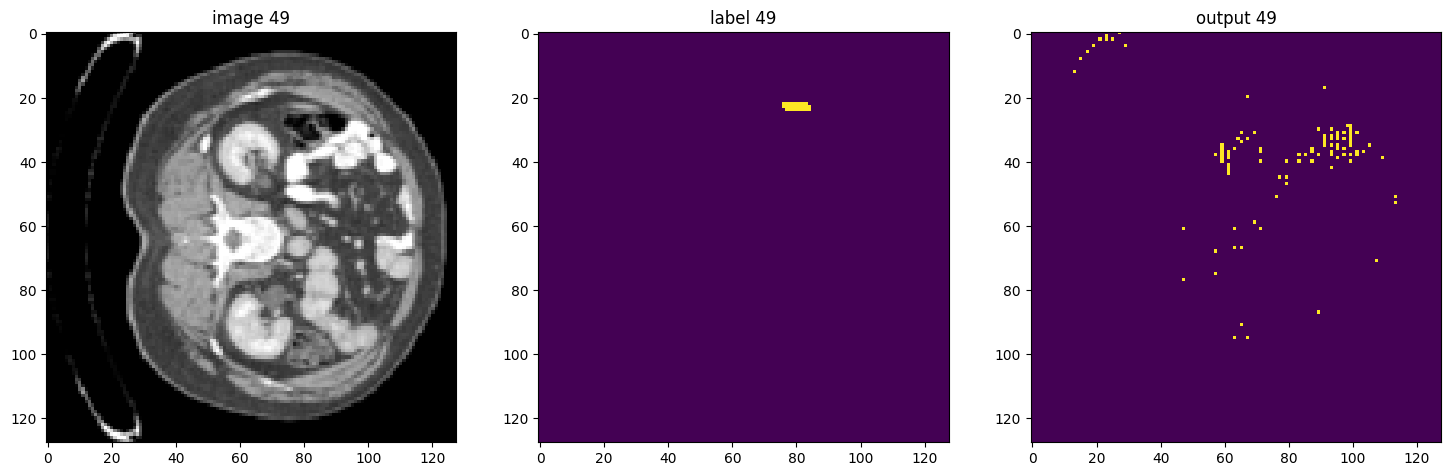

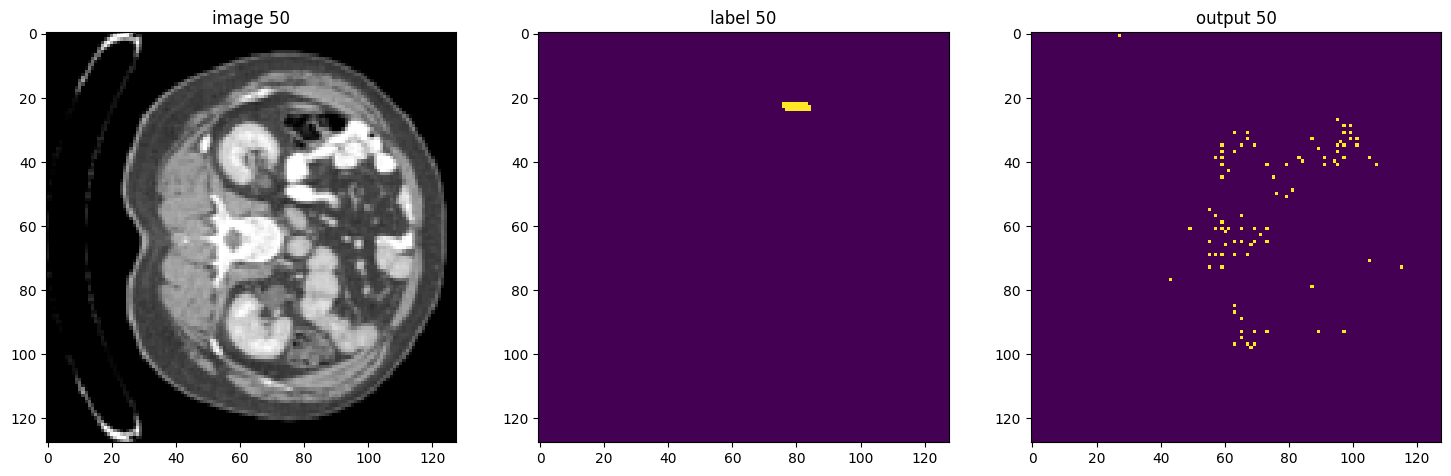

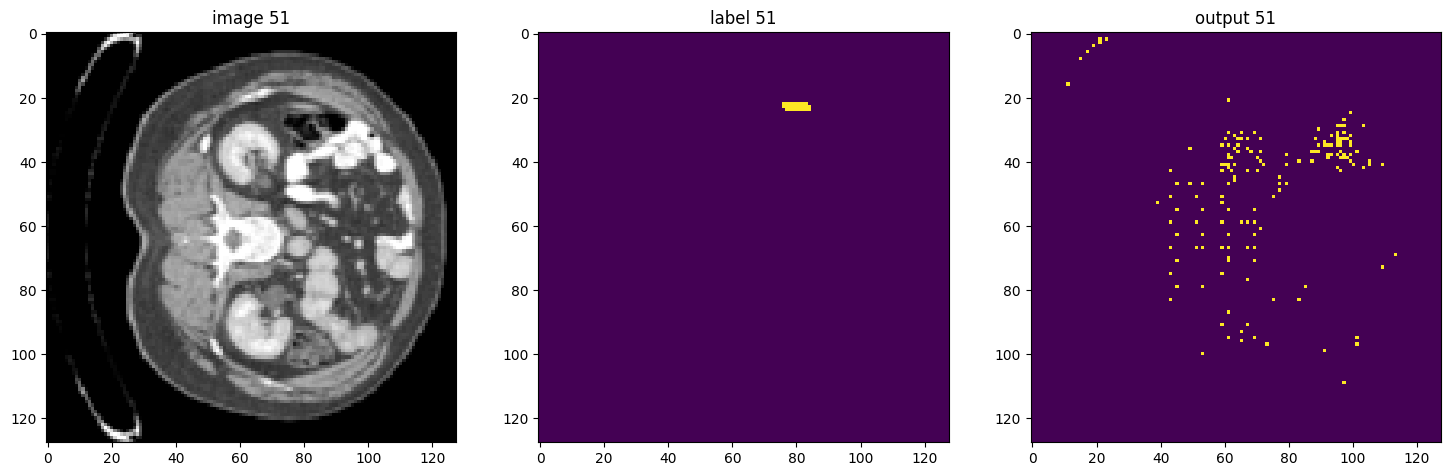

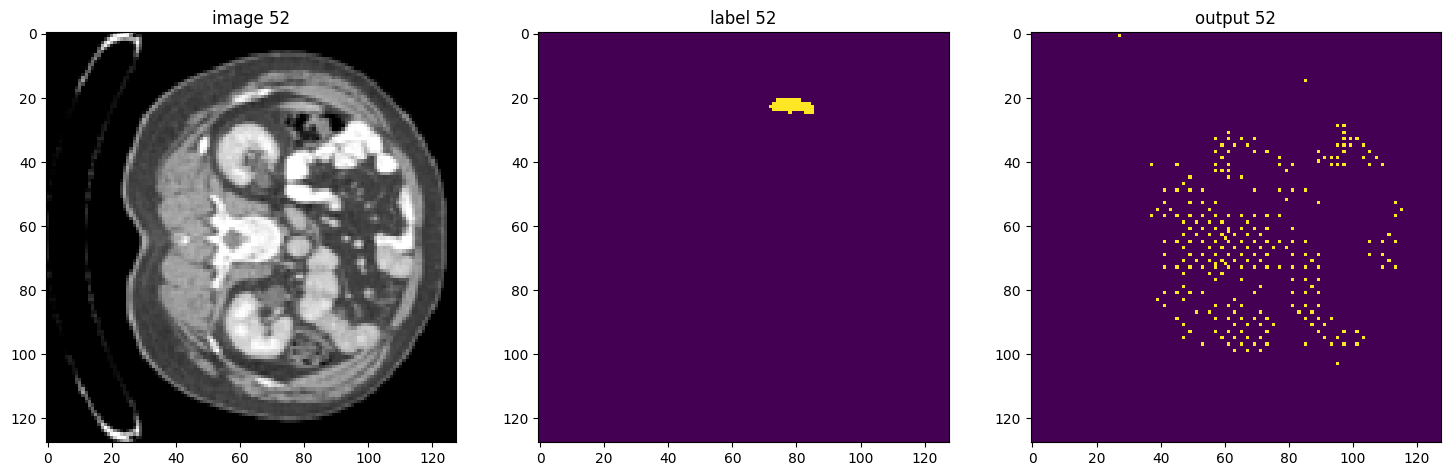

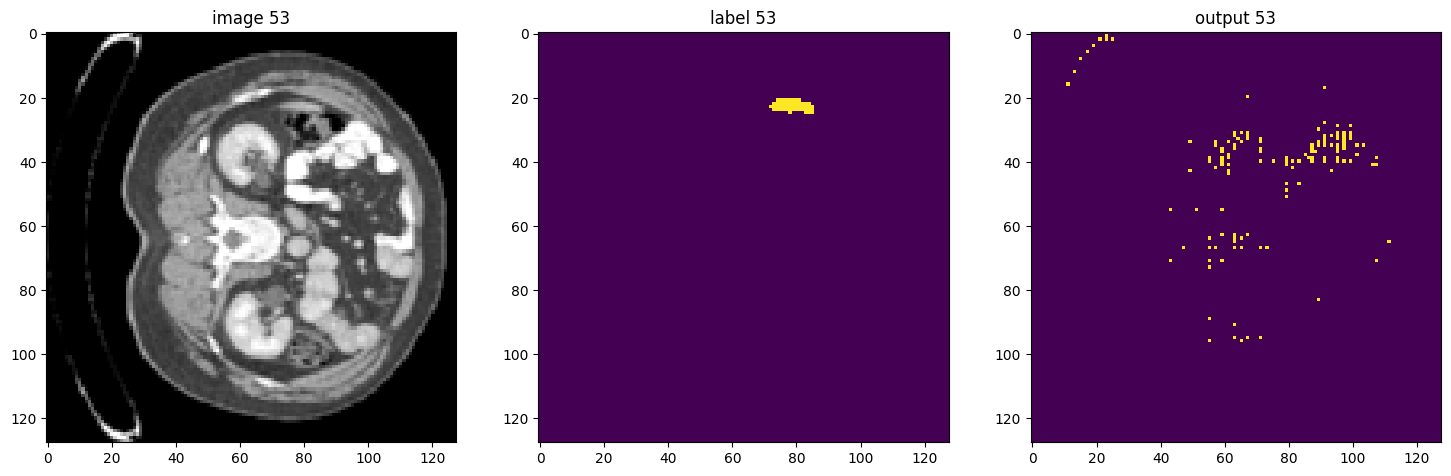

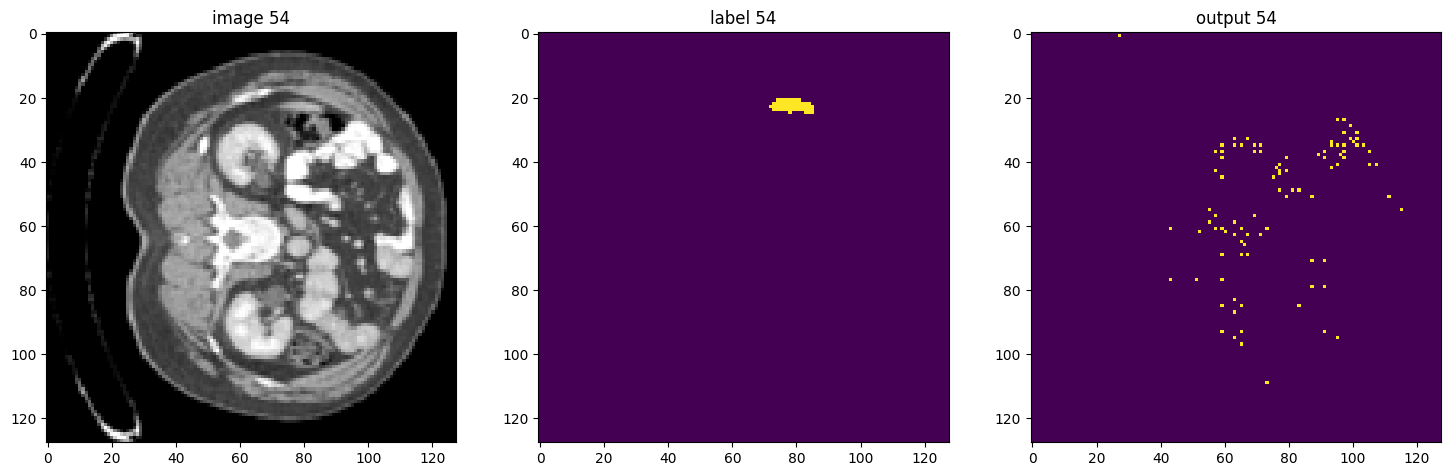

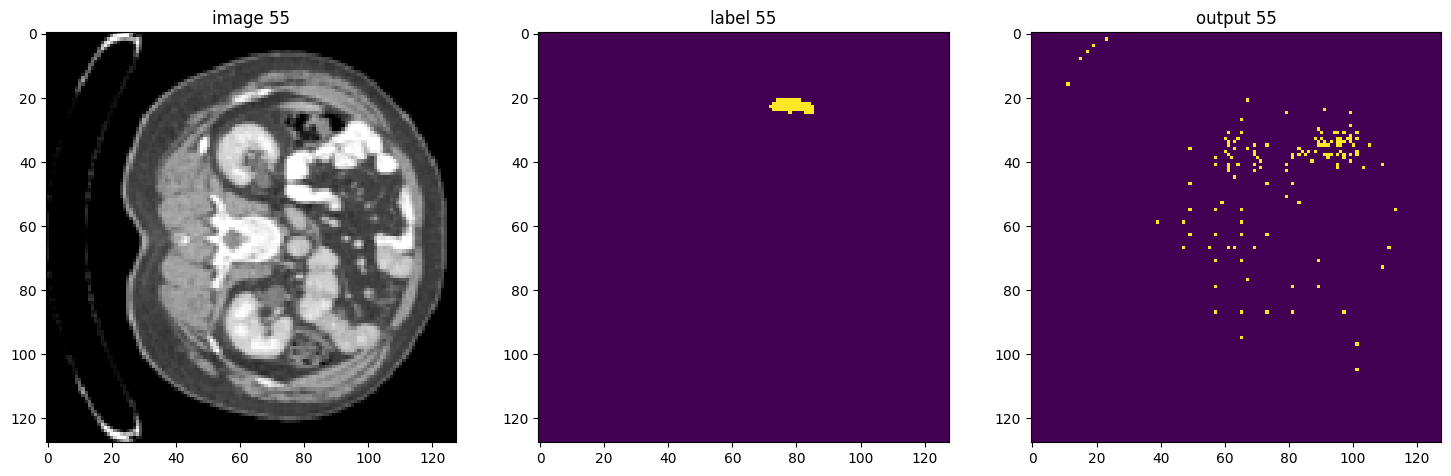

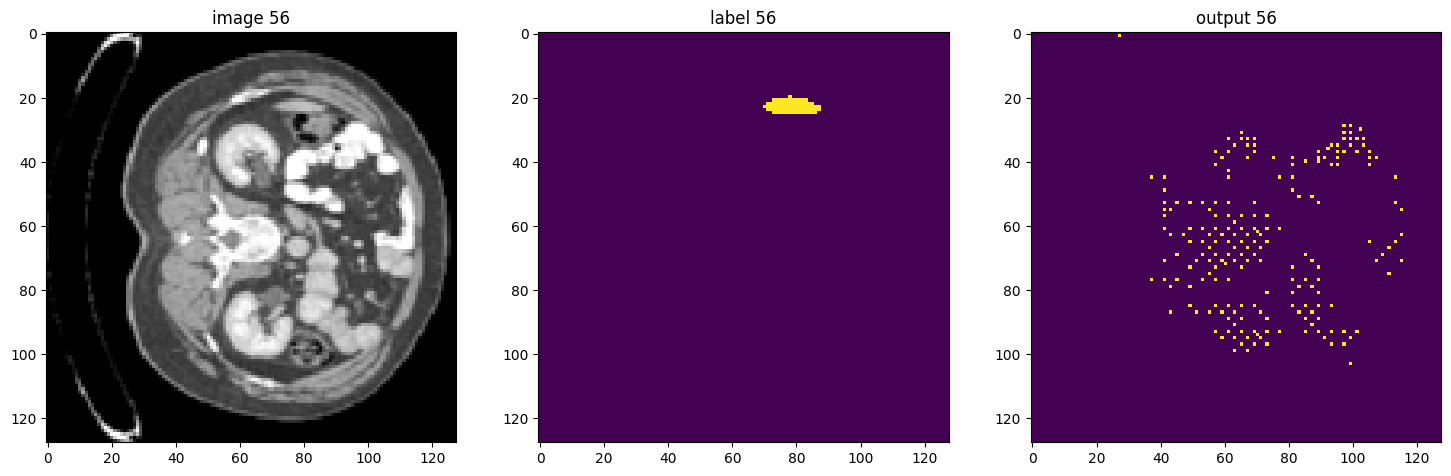

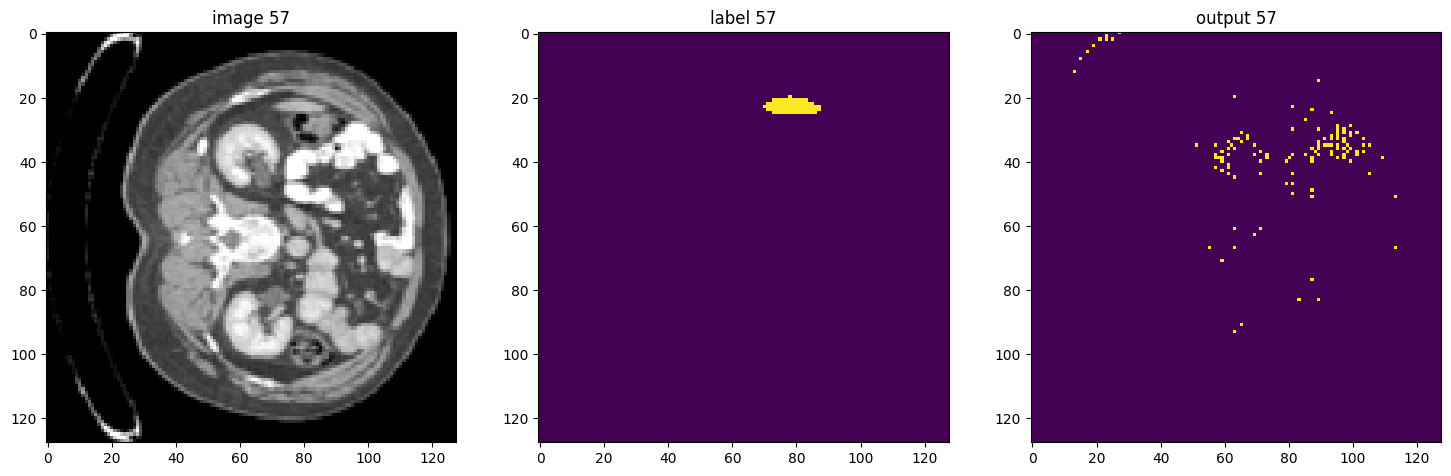

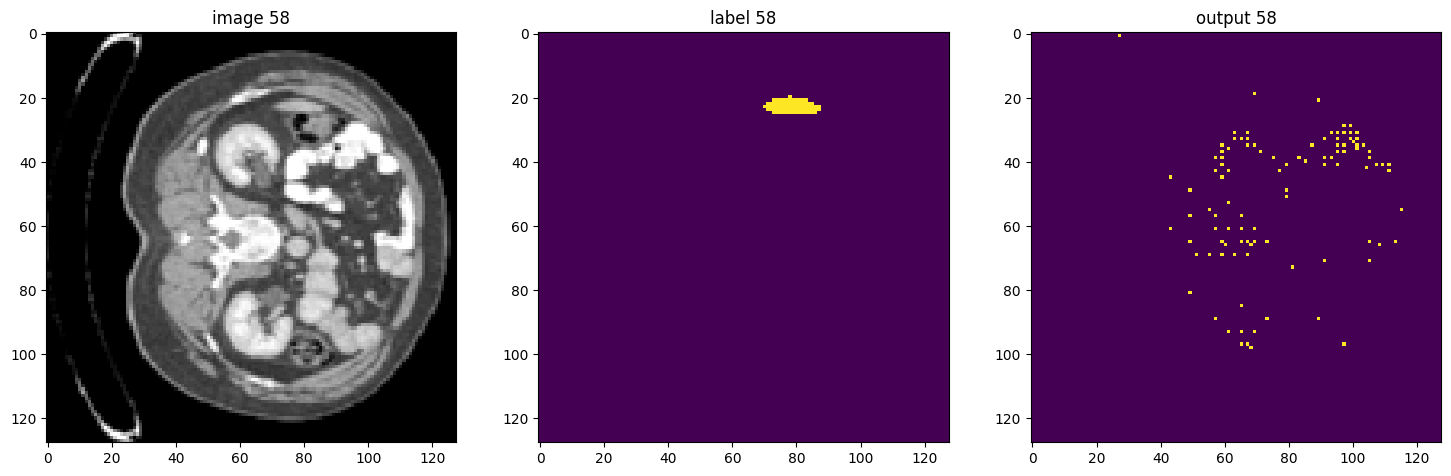

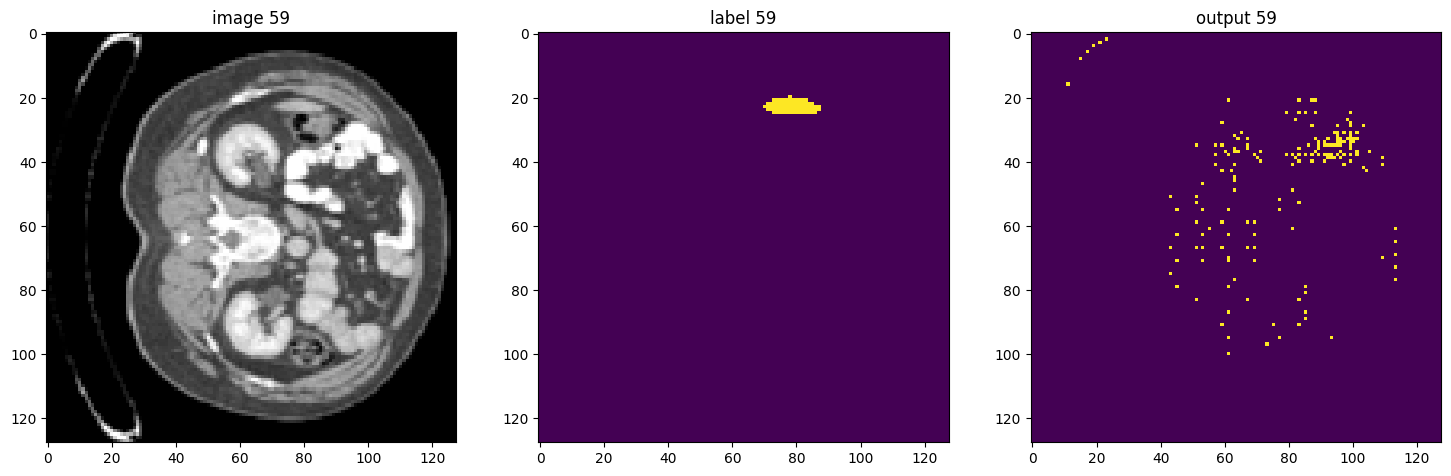

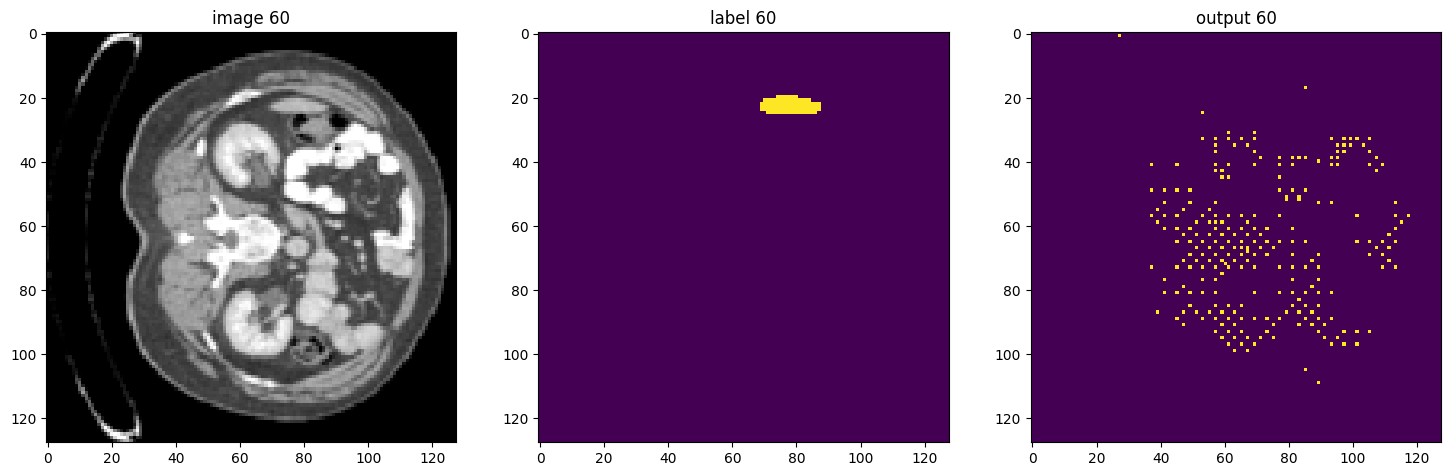

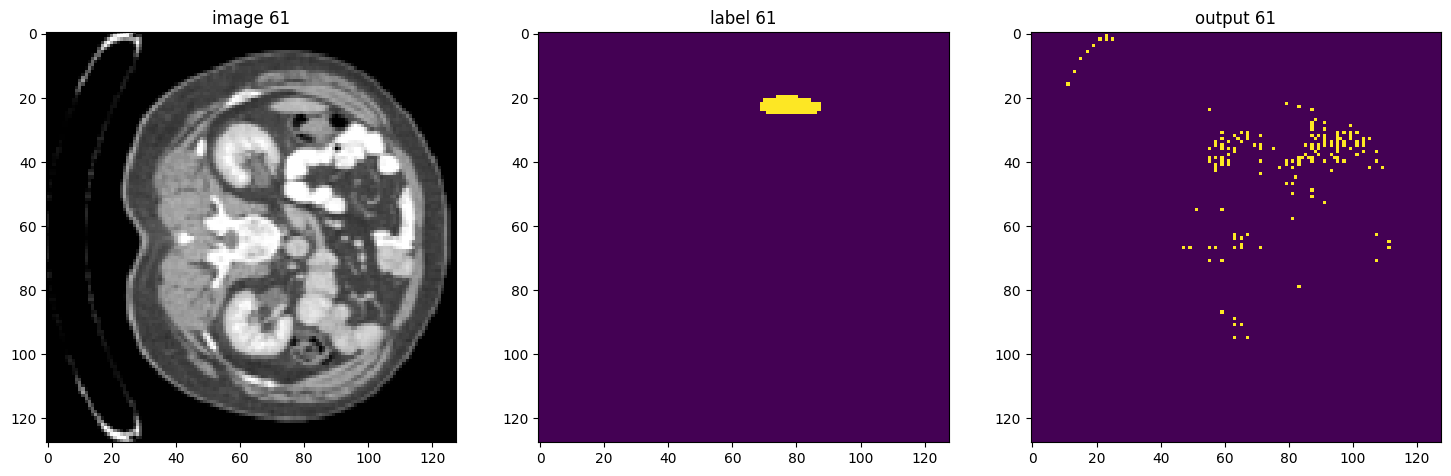

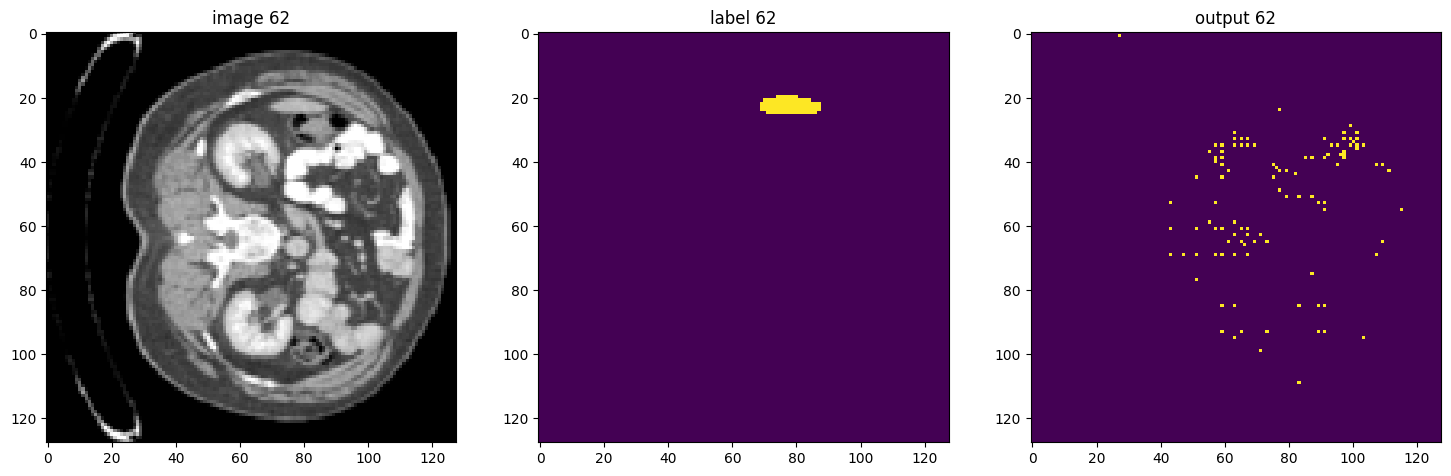

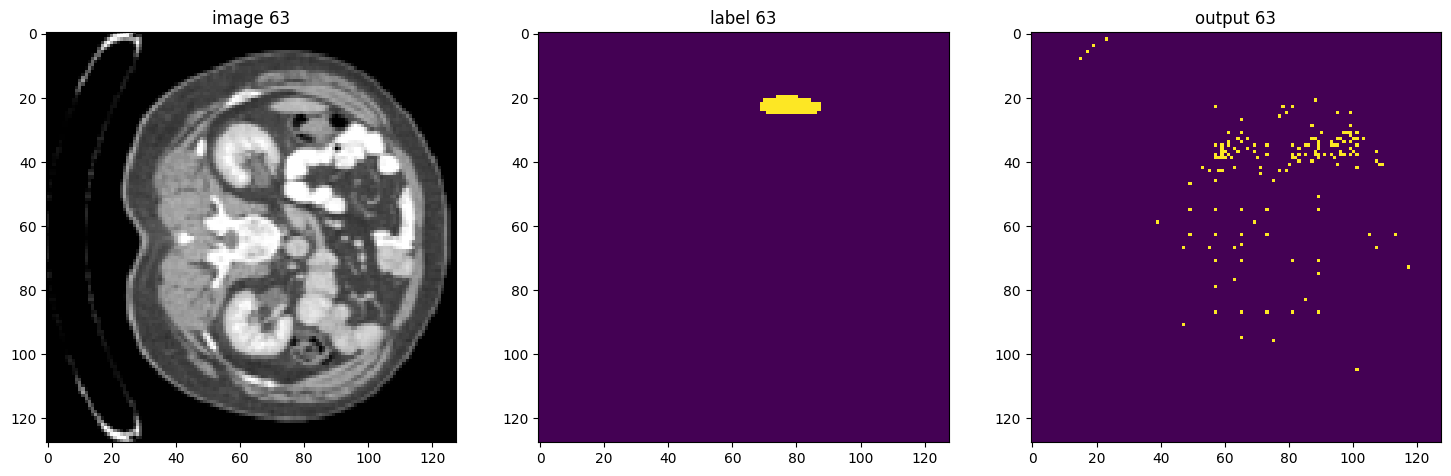

In [26]:
sw_batch_size = 4
roi_size = (128, 128, 128)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['label']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.9

    for i in range(64):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()